In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rl_glue import RLGlue

from environment import BaseEnvironment
from car_racing import CarRacingEnvironment
from agent import BaseAgent 

from collections import deque
from copy import deepcopy
from tqdm import tqdm
import os 
import shutil
from plot_script import plot_result

## Neural Network for action values

We use a neural network with one hidden layer for approximating the action-value function in a control problem. The output layer size is the number of actions. 

The get_action_values() function computes the action-value function by doing a forward pass.
The get_TD_update() function computes the gradient of the action-value function with respect to the weights times the TD error.

In [2]:
class ActionValueNetwork:

    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        self.num_actions = network_config.get("num_actions")
        
        self.rand_generator = np.random.RandomState(network_config.get("seed"))
        
        self.layer_sizes = [self.state_dim, self.num_hidden_units, self.num_actions]
        
        # Initialize the weights of the neural network
        # self.weights is an array of dictionaries with each dictionary corresponding to 
        # the weights from one layer to the next. Each dictionary includes W and b
        self.weights = [dict() for i in range(0, len(self.layer_sizes) - 1)]
        for i in range(0, len(self.layer_sizes) - 1):
            self.weights[i]['W'] = self.init_saxe(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.weights[i]['b'] = np.zeros((1, self.layer_sizes[i + 1]))
    

    def get_action_values(self, s):
        """
        Args:
            s (Numpy array): The state.
        Returns:
            The action-values (Numpy array) calculated using the network's weights.
        """
        
        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)
        
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        q_vals = np.dot(x, W1) + b1

        return q_vals
    

    def get_TD_update(self, s, delta_mat):
        """
        Args:
            s (Numpy array): The state.
            delta_mat (Numpy array): A 2D array of shape (batch_size, num_actions). Each row of delta_mat  
            correspond to one state in the batch. Each row has only one non-zero element 
            which is the TD-error corresponding to the action taken.
        Returns:
            The TD update (Array of dictionaries with gradient times TD errors) for the network's weights
        """

        W0, b0 = self.weights[0]['W'], self.weights[0]['b']
        W1, b1 = self.weights[1]['W'], self.weights[1]['b']
        
        psi = np.dot(s, W0) + b0
        x = np.maximum(psi, 0)
        dx = (psi > 0).astype(float)

        # td_update has the same structure as self.weights, that is an array of dictionaries.
        # td_update[0]["W"], td_update[0]["b"], td_update[1]["W"], and td_update[1]["b"] have the same shape as 
        # self.weights[0]["W"], self.weights[0]["b"], self.weights[1]["W"], and self.weights[1]["b"] respectively
        td_update = [dict() for i in range(len(self.weights))]
         
        v = delta_mat
        td_update[1]['W'] = np.dot(x.T, v) * 1. / s.shape[0]
        td_update[1]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
        
        v = np.dot(v, W1.T) * dx
        td_update[0]['W'] = np.dot(s.T, v) * 1. / s.shape[0]
        td_update[0]['b'] = np.sum(v, axis=0, keepdims=True) * 1. / s.shape[0]
                
        return td_update
    

    def init_saxe(self, rows, cols):
        """
        Args:
            rows (int): number of input units for layer.
            cols (int): number of output units for layer.
        Returns:
            NumPy Array consisting of weights for the layer based on the initialization in Saxe et al.
        """
        tensor = self.rand_generator.normal(0, 1, (rows, cols))
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor
    
  
    def get_weights(self):
        """
        Returns: 
            A copy of the current weights of this network.
        """
        return deepcopy(self.weights)
    
  
    def set_weights(self, weights):
        """
        Args: 
            weights (list of dictionaries): Consists of weights that this network will set as its own weights.
        """
        self.weights = deepcopy(weights)

## Adam Optimizer

In [3]:
class Adam():
    
    def __init__(self, layer_sizes, 
                 optimizer_info):
        self.layer_sizes = layer_sizes

        # Specify Adam algorithm's hyper parameters
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")
        
        # Initialize Adam algorithm's m and v
        self.m = [dict() for i in range(1, len(self.layer_sizes))]
        self.v = [dict() for i in range(1, len(self.layer_sizes))]
        
        for i in range(0, len(self.layer_sizes) - 1):
            
            
            self.m[i]["W"] = np.zeros((self.layer_sizes[i],self.layer_sizes[i+1]))
            self.m[i]["b"] = np.zeros((1, self.layer_sizes[i+1]))
            self.v[i]["W"] = np.zeros((self.layer_sizes[i],self.layer_sizes[i+1]))
            self.v[i]["b"] = np.zeros((1, self.layer_sizes[i+1]))
        
            
            
        # To calculate m_hat and v_hat, we use powers of beta_m and beta_v to 
        # the time step t. We can calculate these powers using an incremental product. At initialization then, 
        # beta_m_product and beta_v_product should be ...? (Note that timesteps start at 1 and if we were to 
        # start from 0, the denominator would be 0.)
        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v
    
    
    def update_weights(self, weights, td_errors_times_gradients):
        """
        Args:
            weights (Array of dictionaries): The weights of the neural network.
            td_errors_times_gradients (Array of dictionaries): The gradient of the 
            action-values with respect to the network's weights times the TD-error
        Returns:
            The updated weights (Array of dictionaries).
        """
        for i in range(len(weights)):
            for param in weights[i].keys():
                
         
                self.m[i][param] = self.beta_m * self.m[i][param] + (1 - self.beta_m) * td_errors_times_gradients[i][param]
                self.v[i][param] = self.beta_v * self.v[i][param] + (1 - self.beta_v) * td_errors_times_gradients[i][param] ** 2
                 
                m_hat = self.m[i][param]/(1-self.beta_m_product)
                v_hat = self.v[i][param]/(1-self.beta_v_product)
                weight_update = self.step_size / (np.sqrt(v_hat) + self.epsilon) * m_hat
                
               
                
                weights[i][param] = weights[i][param] + weight_update
        # To calculate m_hat and v_hat, we use powers of beta_m and beta_v to 
        ### update self.beta_m_product and self.beta_v_product
        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v
        
        return weights

## Replay Buffer

In [4]:
class ReplayBuffer:
    def __init__(self, size, minibatch_size, seed):
        """
        Args:
            size (integer): The size of the replay buffer.              
            minibatch_size (integer): The sample size.
            seed (integer): The seed for the random number generator. 
        """
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState(seed)
        self.max_size = size

    def append(self, state, action, reward, terminal, next_state):
        """
        Args:
            state (Numpy array): The state.              
            action (integer): The action.
            reward (float): The reward.
            terminal (integer): 1 if the next state is a terminal state and 0 otherwise.
            next_state (Numpy array): The next state.           
        """
        if len(self.buffer) == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, terminal, next_state])

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terinal, and next_state
        """
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]

    def size(self):
        return len(self.buffer)

## Softmax

In [5]:
def softmax(action_values, tau=1.0):
    """
    Args:
        action_values (Numpy array): A 2D array of shape (batch_size, num_actions). 
                       The action-values computed by an action-value network.              
        tau (float): The temperature parameter scalar.
    Returns:
        A 2D array of shape (batch_size, num_actions). Where each column is a probability distribution over
        the actions representing the policy.
    """
    
    # Compute the preferences by dividing the action-values by the temperature parameter tau
    preferences = action_values/tau
    # Compute the maximum preference across the actions
    max_preference = np.max(preferences, axis=1)
        
    
    # Reshape max_preference array which has shape [Batch,] to [Batch, 1]. This allows NumPy broadcasting 
    # when subtracting the maximum preference from the preference of each action.
    reshaped_max_preference = max_preference.reshape((-1, 1))
    
    # Compute the numerator, i.e., the exponential of the preference - the max preference.
    exp_preferences = np.exp(preferences - reshaped_max_preference)
    # Compute the denominator, i.e., the sum over the numerator along the actions axis.
    sum_of_exp_preferences = np.sum(exp_preferences, axis=1)
    
   
    
    # Reshape sum_of_exp_preferences array which has shape [Batch,] to [Batch, 1] to  allow for NumPy broadcasting 
    # when dividing the numerator by the denominator.
    reshaped_sum_of_exp_preferences = sum_of_exp_preferences.reshape((-1, 1))
    
    # Compute the action probabilities according to the equation in the previous cell.
    action_probs = exp_preferences/reshaped_sum_of_exp_preferences
    
   
    
    
    # squeeze() removes any singleton dimensions. It is used here because this function is used in the 
    # agent policy when selecting an action (for which the batch dimension is 1.) As np.random.choice is used in 
    # the agent policy and it expects 1D arrays, we need to remove this singleton batch dimension.
    action_probs = action_probs.squeeze()
    return action_probs

## Compiling



In [6]:
def get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau):
    """
    Args:
        states (Numpy array): The batch of states with the shape (batch_size, state_dim).
        next_states (Numpy array): The batch of next states with the shape (batch_size, state_dim).
        actions (Numpy array): The batch of actions with the shape (batch_size,).
        rewards (Numpy array): The batch of rewards with the shape (batch_size,).
        discount (float): The discount factor.
        terminals (Numpy array): The batch of terminals with the shape (batch_size,).
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Returns:
        The TD errors (Numpy array) for actions taken, of shape (batch_size,)
    """
    
    # Here network is the latest state of the network that is getting replay updates. In other words, 
    # the network represents Q_{t+1}^{i} whereas current_q represents Q_t, the fixed network used for computing the 
    # targets, and particularly, the action-values at the next-states.
    
    # Compute action values at next states using current_q network
    # q_next_mat is a 2D array of shape (batch_size, num_actions)
    
    # Q(t+1)
    q_next_mat = current_q.get_action_values(next_states)
 
    
    
    # Compute policy at next state by passing the action-values in q_next_mat to softmax()
    # probs_mat is a 2D array of shape (batch_size, num_actions)
    
    # Pi
    probs_mat = softmax(q_next_mat, tau)

    
    
    # Compute the estimate of the next state value, v_next_vec.
    # v_next_vec is a 1D array of shape (batch_size,)

    v_next_vec = np.sum(probs_mat * q_next_mat, axis=1) * (1-terminals)

    
    
    # Compute Expected Sarsa target
    # target_vec is a 1D array of shape (batch_size,)
    
    # 
    target_vec = rewards + discount*v_next_vec

    
    
    # Compute action values at the current states for all actions using network
    # q_mat is a 2D array of shape (batch_size, num_actions)
   
    q_mat = network.get_action_values(states)
   
    
    # Batch Indices is an array from 0 to the batch size - 1. 
    batch_indices = np.arange(q_mat.shape[0])

    # Compute q_vec by selecting q(s, a) from q_mat for taken actions
    # Use batch_indices as the index for the first dimension of q_mat
    # q_vec is a 1D array of shape (batch_size)
    
    q_vec = q_mat[batch_indices, actions]

    
    
    # Compute TD errors for actions taken
    # delta_vec is a 1D array of shape (batch_size)
    
    delta_vec = target_vec - q_vec
    
    
    return delta_vec

In [7]:
def optimize_network(experiences, discount, optimizer, network, current_q, tau):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    """
    
    # Get states, action, rewards, terminals, and next_states from experiences
    states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = np.concatenate(states)
    next_states = np.concatenate(next_states)
    rewards = np.array(rewards)
    terminals = np.array(terminals)
    batch_size = states.shape[0]

    # Compute TD error using the get_td_error function
    # q_vec is a 1D array of shape (batch_size)
    delta_vec = get_td_error(states, next_states, actions, rewards, discount, terminals, network, current_q, tau)

    # Batch Indices is an array from 0 to the batch_size - 1. 
    batch_indices = np.arange(batch_size)

    # Make a td error matrix of shape (batch_size, num_actions)
    # delta_mat has non-zero value only for actions taken
    delta_mat = np.zeros((batch_size, network.num_actions))
    delta_mat[batch_indices, actions] = delta_vec

    # Pass delta_mat to compute the TD errors times the gradients of the network's weights from back-propagation
    td_update = network.get_TD_update(states, delta_mat)

    
    
    # Pass network.get_weights and the td_update to the optimizer to get updated weights
    weights = optimizer.update_weights(network.get_weights(), td_update)
    
    
    network.set_weights(weights)

## Agent


In [8]:
class Agent(BaseAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"
        
    def agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer, 
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        self.replay_buffer = ReplayBuffer(agent_config['replay_buffer_size'], 
                                          agent_config['minibatch_sz'], agent_config.get("seed"))
        self.network = ActionValueNetwork(agent_config['network_config'])
        self.optimizer = Adam(self.network.layer_sizes, agent_config["optimizer_config"])
        self.num_actions = agent_config['network_config']['num_actions']
        self.num_replay = agent_config['num_replay_updates_per_step']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        
        self.last_state = None
        self.last_action = None
        
        self.sum_rewards = 0
        self.episode_steps = 0

    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action. 
        """
        action_values = self.network.get_action_values(state)
        probs_batch = softmax(action_values, self.tau)
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        return action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        self.sum_rewards = 0
        self.episode_steps = 0
        self.last_state = np.array([state])
        self.last_action = self.policy(self.last_state)
        return self.last_action


    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        self.sum_rewards += reward
        self.episode_steps += 1

        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        action = self.policy(state)
        
        # Append new experience to replay buffer
        self.replay_buffer.append(self.last_state, self.last_action, reward, 0, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network 
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)
                
        # Update the last state and last action.
        self.last_state = state
        self.last_action = action

        
        
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.sum_rewards += reward
        self.episode_steps += 1
        
        # Set terminal state to an array of zeros
        state = np.zeros_like(self.last_state)

        # Append new experience to replay buffer       
       
        self.replay_buffer.append(self.last_state, self.last_action, reward, 1, state)
        
        # Perform replay steps:
        if self.replay_buffer.size() > self.replay_buffer.minibatch_size:
            current_q = deepcopy(self.network)
            for _ in range(self.num_replay):
                
                # Get sample experiences from the replay buffer
                experiences = self.replay_buffer.sample()
                
                # Call optimize_network to update the weights of the network
                optimize_network(experiences, self.discount, self.optimizer, self.network, current_q, self.tau)
                
        
    def trained_agent_step(self, reward, state):
        """A step taken by the trained agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        
        
        self.sum_rewards += reward
        # Make state an array of shape (1, state_dim) to add a batch dimension and
        # to later match the get_action_values() and get_TD_update() functions
        state = np.array([state])

        # Select action
        action = self.policy(state)
        
        return action
    
    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        else:
            raise Exception("Unrecognized Message!")

## Run the experiment

In [9]:

def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))
    trained_agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes_trained"]))

    env_info = {}

    agent_info = agent_parameters

    # one agent setting
    for run in range(1, experiment_parameters["num_runs"]+1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)

            
        for episode in tqdm(range(1, experiment_parameters["num_episodes"]+1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])
            
            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward
          
        
        for episode in range(1, experiment_parameters["num_episodes_trained"]+1):
            rl_glue.trained_rl_episode(experiment_parameters["timeout"])
            trained_agent_sum_reward[run - 1, episode - 1 ] =  rl_glue.rl_env_message("get_sum_reward")
            
            print("Trained reward = " + str(trained_agent_sum_reward))
    save_name = "{}".format(rl_glue.agent.name)
    if not os.path.exists('results'):
        os.makedirs('results')
    np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
    shutil.make_archive('results', 'zip', 'results')

# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 1,
    "num_episodes_trained" : 10,
    "num_episodes" : 1000,
    # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after 
    # some number of timesteps. Here we use the default of 500.
    "timeout" : 500
}

# Environment parameters
environment_parameters = {}

current_env = CarRacingEnvironment

# Agent parameters
agent_parameters = {
    'network_config': {
        'state_dim': 9216,
        'num_hidden_units': 256,
        'num_actions': 5
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 1,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 4,
    'gamma': 0.99,
    'tau': 0.001
}
current_agent = Agent

# run experiment
run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

C:\Users\Kirat\Anaconda3\envs\TensorGPU, Keras\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Track generation: 1143..1442 -> 299-tiles track


  0%|                                                                               | 1/1000 [00:04<1:16:39,  4.60s/it]

Track generation: 1087..1369 -> 282-tiles track


  0%|▏                                                                              | 2/1000 [00:08<1:05:54,  3.96s/it]

Track generation: 964..1212 -> 248-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1176..1474 -> 298-tiles track


  0%|▏                                                                              | 3/1000 [00:11<1:02:29,  3.76s/it]

Track generation: 1283..1608 -> 325-tiles track


  0%|▎                                                                              | 4/1000 [00:15<1:01:00,  3.67s/it]

Track generation: 1217..1526 -> 309-tiles track


  0%|▍                                                                              | 5/1000 [00:19<1:02:07,  3.75s/it]

Track generation: 1096..1374 -> 278-tiles track


  1%|▍                                                                              | 6/1000 [00:22<1:01:58,  3.74s/it]

Track generation: 1198..1501 -> 303-tiles track


  1%|▌                                                                              | 7/1000 [00:26<1:03:08,  3.82s/it]

Track generation: 1159..1453 -> 294-tiles track


  1%|▋                                                                              | 8/1000 [00:30<1:01:30,  3.72s/it]

Track generation: 957..1205 -> 248-tiles track


  1%|▋                                                                              | 9/1000 [00:34<1:01:42,  3.74s/it]

Track generation: 1181..1480 -> 299-tiles track


  1%|▊                                                                             | 10/1000 [00:37<1:02:24,  3.78s/it]

Track generation: 979..1234 -> 255-tiles track


  1%|▊                                                                             | 11/1000 [00:41<1:00:17,  3.66s/it]

Track generation: 1320..1654 -> 334-tiles track


  1%|▉                                                                             | 12/1000 [00:45<1:00:50,  3.69s/it]

Track generation: 1067..1338 -> 271-tiles track


  1%|█                                                                             | 13/1000 [00:48<1:00:26,  3.67s/it]

Track generation: 1067..1338 -> 271-tiles track


  1%|█                                                                             | 14/1000 [00:52<1:00:08,  3.66s/it]

Track generation: 1207..1513 -> 306-tiles track


  2%|█▏                                                                              | 15/1000 [00:55<59:50,  3.65s/it]

Track generation: 1106..1396 -> 290-tiles track


  2%|█▎                                                                              | 16/1000 [00:59<59:43,  3.64s/it]

Track generation: 1296..1628 -> 332-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1047..1319 -> 272-tiles track


  2%|█▎                                                                              | 17/1000 [01:03<58:45,  3.59s/it]

Track generation: 1245..1560 -> 315-tiles track


  2%|█▍                                                                              | 18/1000 [01:06<59:57,  3.66s/it]

Track generation: 1232..1544 -> 312-tiles track


  2%|█▌                                                                              | 19/1000 [01:10<59:59,  3.67s/it]

Track generation: 1120..1408 -> 288-tiles track


  2%|█▌                                                                              | 20/1000 [01:14<59:41,  3.65s/it]

Track generation: 1225..1536 -> 311-tiles track


  2%|█▋                                                                              | 21/1000 [01:17<59:19,  3.64s/it]

Track generation: 1077..1357 -> 280-tiles track


  2%|█▊                                                                              | 22/1000 [01:21<59:13,  3.63s/it]

Track generation: 1322..1664 -> 342-tiles track


  2%|█▊                                                                            | 23/1000 [01:25<1:00:16,  3.70s/it]

Track generation: 1035..1297 -> 262-tiles track


  2%|█▉                                                                              | 24/1000 [01:28<58:56,  3.62s/it]

Track generation: 1297..1626 -> 329-tiles track


  2%|██                                                                              | 25/1000 [01:32<59:26,  3.66s/it]

Track generation: 1294..1621 -> 327-tiles track


  3%|██                                                                              | 26/1000 [01:36<59:31,  3.67s/it]

Track generation: 1055..1331 -> 276-tiles track


  3%|██▏                                                                             | 27/1000 [01:39<59:18,  3.66s/it]

Track generation: 1202..1507 -> 305-tiles track


  3%|██▏                                                                             | 28/1000 [01:43<59:14,  3.66s/it]

Track generation: 863..1087 -> 224-tiles track


  3%|██▎                                                                             | 29/1000 [01:46<57:48,  3.57s/it]

Track generation: 1227..1538 -> 311-tiles track


  3%|██▍                                                                             | 30/1000 [01:50<57:36,  3.56s/it]

Track generation: 1317..1652 -> 335-tiles track


  3%|██▍                                                                             | 31/1000 [01:54<59:04,  3.66s/it]

Track generation: 1115..1402 -> 287-tiles track


  3%|██▌                                                                             | 32/1000 [01:57<59:22,  3.68s/it]

Track generation: 1168..1464 -> 296-tiles track


  3%|██▋                                                                             | 33/1000 [02:01<58:45,  3.65s/it]

Track generation: 1056..1324 -> 268-tiles track


  3%|██▋                                                                             | 34/1000 [02:05<58:03,  3.61s/it]

Track generation: 1204..1509 -> 305-tiles track


  4%|██▊                                                                             | 35/1000 [02:08<58:29,  3.64s/it]

Track generation: 1260..1579 -> 319-tiles track


  4%|██▊                                                                           | 36/1000 [02:12<1:00:51,  3.79s/it]

Track generation: 1100..1379 -> 279-tiles track


  4%|██▉                                                                           | 37/1000 [02:16<1:00:17,  3.76s/it]

Track generation: 1185..1485 -> 300-tiles track


  4%|██▉                                                                           | 38/1000 [02:20<1:00:50,  3.79s/it]

Track generation: 1034..1296 -> 262-tiles track


  4%|███                                                                           | 39/1000 [02:24<1:02:25,  3.90s/it]

Track generation: 1076..1352 -> 276-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1132..1419 -> 287-tiles track


  4%|███                                                                           | 40/1000 [02:28<1:02:02,  3.88s/it]

Track generation: 1292..1619 -> 327-tiles track


  4%|███▏                                                                          | 41/1000 [02:32<1:01:42,  3.86s/it]

Track generation: 1275..1598 -> 323-tiles track


  4%|███▎                                                                          | 42/1000 [02:35<1:00:46,  3.81s/it]

Track generation: 1056..1324 -> 268-tiles track


  4%|███▍                                                                            | 43/1000 [02:39<59:08,  3.71s/it]

Track generation: 1092..1377 -> 285-tiles track


  4%|███▍                                                                          | 44/1000 [02:43<1:00:23,  3.79s/it]

Track generation: 1127..1413 -> 286-tiles track


  4%|███▌                                                                            | 45/1000 [02:46<59:18,  3.73s/it]

Track generation: 1104..1384 -> 280-tiles track


  5%|███▋                                                                            | 46/1000 [02:50<58:17,  3.67s/it]

Track generation: 1131..1430 -> 299-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1195..1498 -> 303-tiles track


  5%|███▊                                                                            | 47/1000 [02:54<58:07,  3.66s/it]

Track generation: 1155..1448 -> 293-tiles track


  5%|███▊                                                                            | 48/1000 [02:57<58:42,  3.70s/it]

Track generation: 1317..1650 -> 333-tiles track


  5%|███▉                                                                            | 49/1000 [03:01<59:23,  3.75s/it]

Track generation: 1180..1479 -> 299-tiles track


  5%|████                                                                            | 50/1000 [03:05<58:39,  3.70s/it]

Track generation: 1170..1467 -> 297-tiles track


  5%|████                                                                            | 51/1000 [03:08<57:58,  3.67s/it]

Track generation: 1022..1282 -> 260-tiles track


  5%|████▏                                                                           | 52/1000 [03:12<57:23,  3.63s/it]

Track generation: 1230..1542 -> 312-tiles track


  5%|████▏                                                                           | 53/1000 [03:16<57:59,  3.67s/it]

Track generation: 1018..1278 -> 260-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1126..1412 -> 286-tiles track


  5%|████▎                                                                           | 54/1000 [03:19<57:33,  3.65s/it]

Track generation: 1251..1568 -> 317-tiles track


  6%|████▍                                                                           | 55/1000 [03:23<57:22,  3.64s/it]

Track generation: 1202..1507 -> 305-tiles track


  6%|████▍                                                                           | 56/1000 [03:27<57:22,  3.65s/it]

Track generation: 1265..1592 -> 327-tiles track


  6%|████▌                                                                           | 57/1000 [03:31<58:48,  3.74s/it]

Track generation: 1049..1315 -> 266-tiles track


  6%|████▋                                                                           | 58/1000 [03:34<57:59,  3.69s/it]

Track generation: 1345..1685 -> 340-tiles track


  6%|████▋                                                                           | 59/1000 [03:38<57:46,  3.68s/it]

Track generation: 929..1167 -> 238-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1059..1328 -> 269-tiles track


  6%|████▊                                                                           | 60/1000 [03:41<56:52,  3.63s/it]

Track generation: 981..1236 -> 255-tiles track


  6%|████▉                                                                           | 61/1000 [03:45<57:12,  3.66s/it]

Track generation: 1220..1529 -> 309-tiles track


  6%|████▉                                                                           | 62/1000 [03:49<57:27,  3.68s/it]

Track generation: 1062..1332 -> 270-tiles track


  6%|█████                                                                           | 63/1000 [03:52<56:27,  3.61s/it]

Track generation: 1148..1439 -> 291-tiles track


  6%|█████                                                                           | 64/1000 [03:56<56:02,  3.59s/it]

Track generation: 983..1235 -> 252-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1106..1387 -> 281-tiles track


  6%|█████▏                                                                          | 65/1000 [03:59<56:08,  3.60s/it]

Track generation: 1068..1339 -> 271-tiles track


  7%|█████▎                                                                          | 66/1000 [04:03<56:42,  3.64s/it]

Track generation: 1285..1611 -> 326-tiles track


  7%|█████▎                                                                          | 67/1000 [04:07<56:47,  3.65s/it]

Track generation: 1224..1534 -> 310-tiles track


  7%|█████▍                                                                          | 68/1000 [04:11<56:52,  3.66s/it]

Track generation: 1095..1373 -> 278-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1209..1515 -> 306-tiles track


  7%|█████▌                                                                          | 69/1000 [04:14<56:26,  3.64s/it]

Track generation: 1167..1463 -> 296-tiles track


  7%|█████▌                                                                          | 70/1000 [04:18<57:29,  3.71s/it]

Track generation: 1215..1523 -> 308-tiles track


  7%|█████▋                                                                          | 71/1000 [04:22<57:22,  3.71s/it]

Track generation: 1292..1619 -> 327-tiles track


  7%|█████▊                                                                          | 72/1000 [04:26<57:59,  3.75s/it]

Track generation: 1099..1378 -> 279-tiles track


  7%|█████▊                                                                          | 73/1000 [04:29<56:47,  3.68s/it]

Track generation: 1179..1478 -> 299-tiles track


  7%|█████▉                                                                          | 74/1000 [04:33<57:00,  3.69s/it]

Track generation: 1107..1388 -> 281-tiles track


  8%|██████                                                                          | 75/1000 [04:36<56:47,  3.68s/it]

Track generation: 1209..1519 -> 310-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1233..1544 -> 311-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1234..1555 -> 321-tiles track


  8%|██████                                                                          | 76/1000 [04:40<56:59,  3.70s/it]

Track generation: 1232..1553 -> 321-tiles track


  8%|██████▏                                                                         | 77/1000 [04:44<57:00,  3.71s/it]

Track generation: 1214..1522 -> 308-tiles track


  8%|██████▏                                                                         | 78/1000 [04:48<57:50,  3.76s/it]

Track generation: 1151..1450 -> 299-tiles track


  8%|██████▎                                                                         | 79/1000 [04:52<57:37,  3.75s/it]

Track generation: 1213..1529 -> 316-tiles track


  8%|██████▍                                                                         | 80/1000 [04:55<56:56,  3.71s/it]

Track generation: 1252..1569 -> 317-tiles track


  8%|██████▍                                                                         | 81/1000 [04:59<56:42,  3.70s/it]

Track generation: 1040..1304 -> 264-tiles track


  8%|██████▌                                                                         | 82/1000 [05:02<55:33,  3.63s/it]

Track generation: 1128..1414 -> 286-tiles track


  8%|██████▋                                                                         | 83/1000 [05:06<56:03,  3.67s/it]

Track generation: 1121..1408 -> 287-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1048..1319 -> 271-tiles track


  8%|██████▋                                                                         | 84/1000 [05:10<55:29,  3.64s/it]

Track generation: 1224..1534 -> 310-tiles track


  8%|██████▊                                                                         | 85/1000 [05:13<55:30,  3.64s/it]

Track generation: 1140..1429 -> 289-tiles track


  9%|██████▉                                                                         | 86/1000 [05:17<54:55,  3.61s/it]

Track generation: 1114..1400 -> 286-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1052..1319 -> 267-tiles track


  9%|██████▉                                                                         | 87/1000 [05:20<54:53,  3.61s/it]

Track generation: 1045..1313 -> 268-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1131..1418 -> 287-tiles track


  9%|███████                                                                         | 88/1000 [05:24<56:33,  3.72s/it]

Track generation: 1122..1412 -> 290-tiles track


  9%|███████                                                                         | 89/1000 [05:28<56:11,  3.70s/it]

Track generation: 1239..1553 -> 314-tiles track


  9%|███████▏                                                                        | 90/1000 [05:32<55:49,  3.68s/it]

Track generation: 1022..1283 -> 261-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1123..1408 -> 285-tiles track


  9%|███████▎                                                                        | 91/1000 [05:35<55:22,  3.65s/it]

Track generation: 1158..1462 -> 304-tiles track


  9%|███████▎                                                                        | 92/1000 [05:39<55:59,  3.70s/it]

Track generation: 1313..1645 -> 332-tiles track


  9%|███████▍                                                                        | 93/1000 [05:43<56:01,  3.71s/it]

Track generation: 1000..1254 -> 254-tiles track


  9%|███████▌                                                                        | 94/1000 [05:46<55:33,  3.68s/it]

Track generation: 1259..1578 -> 319-tiles track


 10%|███████▌                                                                        | 95/1000 [05:50<54:54,  3.64s/it]

Track generation: 1316..1655 -> 339-tiles track


 10%|███████▋                                                                        | 96/1000 [05:54<55:58,  3.71s/it]

Track generation: 1086..1367 -> 281-tiles track


 10%|███████▊                                                                        | 97/1000 [05:57<55:38,  3.70s/it]

Track generation: 988..1238 -> 250-tiles track


 10%|███████▊                                                                        | 98/1000 [06:01<54:22,  3.62s/it]

Track generation: 1072..1344 -> 272-tiles track


 10%|███████▉                                                                        | 99/1000 [06:04<54:00,  3.60s/it]

Track generation: 1152..1444 -> 292-tiles track


 10%|███████▉                                                                       | 100/1000 [06:08<54:09,  3.61s/it]

Track generation: 1066..1341 -> 275-tiles track


 10%|███████▉                                                                       | 101/1000 [06:12<54:15,  3.62s/it]

Track generation: 1070..1341 -> 271-tiles track


 10%|████████                                                                       | 102/1000 [06:15<54:00,  3.61s/it]

Track generation: 1231..1543 -> 312-tiles track


 10%|████████▏                                                                      | 103/1000 [06:19<54:32,  3.65s/it]

Track generation: 1168..1464 -> 296-tiles track


 10%|████████▏                                                                      | 104/1000 [06:23<54:13,  3.63s/it]

Track generation: 1020..1279 -> 259-tiles track


 10%|████████▎                                                                      | 105/1000 [06:26<54:56,  3.68s/it]

Track generation: 1080..1359 -> 279-tiles track


 11%|████████▎                                                                      | 106/1000 [06:30<54:27,  3.65s/it]

Track generation: 1275..1598 -> 323-tiles track


 11%|████████▍                                                                      | 107/1000 [06:34<54:40,  3.67s/it]

Track generation: 1099..1381 -> 282-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1063..1333 -> 270-tiles track


 11%|████████▌                                                                      | 108/1000 [06:37<53:51,  3.62s/it]

Track generation: 1123..1408 -> 285-tiles track


 11%|████████▌                                                                      | 109/1000 [06:41<54:43,  3.69s/it]

Track generation: 1228..1539 -> 311-tiles track


 11%|████████▋                                                                      | 110/1000 [06:45<54:58,  3.71s/it]

Track generation: 1151..1443 -> 292-tiles track


 11%|████████▊                                                                      | 111/1000 [06:49<55:05,  3.72s/it]

Track generation: 1171..1468 -> 297-tiles track


 11%|████████▊                                                                      | 112/1000 [06:52<54:32,  3.68s/it]

Track generation: 1212..1519 -> 307-tiles track


 11%|████████▉                                                                      | 113/1000 [06:56<54:54,  3.71s/it]

Track generation: 1270..1592 -> 322-tiles track


 11%|█████████                                                                      | 114/1000 [07:00<55:43,  3.77s/it]

Track generation: 1248..1564 -> 316-tiles track


 12%|█████████                                                                      | 115/1000 [07:04<55:07,  3.74s/it]

Track generation: 1096..1374 -> 278-tiles track


 12%|█████████▏                                                                     | 116/1000 [07:07<54:15,  3.68s/it]

Track generation: 1119..1403 -> 284-tiles track


 12%|█████████▏                                                                     | 117/1000 [07:11<53:46,  3.65s/it]

Track generation: 1154..1447 -> 293-tiles track


 12%|█████████▎                                                                     | 118/1000 [07:15<54:30,  3.71s/it]

Track generation: 1171..1468 -> 297-tiles track


 12%|█████████▍                                                                     | 119/1000 [07:18<53:46,  3.66s/it]

Track generation: 1139..1428 -> 289-tiles track


 12%|█████████▍                                                                     | 120/1000 [07:22<54:05,  3.69s/it]

Track generation: 1061..1339 -> 278-tiles track


 12%|█████████▌                                                                     | 121/1000 [07:25<53:34,  3.66s/it]

Track generation: 1006..1269 -> 263-tiles track


 12%|█████████▋                                                                     | 122/1000 [07:29<53:52,  3.68s/it]

Track generation: 1161..1455 -> 294-tiles track


 12%|█████████▋                                                                     | 123/1000 [07:33<56:07,  3.84s/it]

Track generation: 1156..1448 -> 292-tiles track


 12%|█████████▊                                                                     | 124/1000 [07:37<55:22,  3.79s/it]

Track generation: 1207..1513 -> 306-tiles track


 12%|█████████▉                                                                     | 125/1000 [07:41<56:10,  3.85s/it]

Track generation: 1114..1397 -> 283-tiles track


 13%|█████████▉                                                                     | 126/1000 [07:45<56:09,  3.85s/it]

Track generation: 1114..1405 -> 291-tiles track


 13%|██████████                                                                     | 127/1000 [07:49<55:49,  3.84s/it]

Track generation: 1332..1669 -> 337-tiles track


 13%|██████████                                                                     | 128/1000 [07:53<55:54,  3.85s/it]

Track generation: 1019..1278 -> 259-tiles track


 13%|██████████▏                                                                    | 129/1000 [07:56<54:46,  3.77s/it]

Track generation: 1102..1380 -> 278-tiles track


 13%|██████████▎                                                                    | 130/1000 [08:00<53:59,  3.72s/it]

Track generation: 1065..1342 -> 277-tiles track


 13%|██████████▎                                                                    | 131/1000 [08:04<54:18,  3.75s/it]

Track generation: 1123..1410 -> 287-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1204..1509 -> 305-tiles track


 13%|██████████▍                                                                    | 132/1000 [08:07<53:49,  3.72s/it]

Track generation: 1199..1503 -> 304-tiles track


 13%|██████████▌                                                                    | 133/1000 [08:11<53:08,  3.68s/it]

Track generation: 1059..1328 -> 269-tiles track


 13%|██████████▌                                                                    | 134/1000 [08:14<52:21,  3.63s/it]

Track generation: 945..1191 -> 246-tiles track


 14%|██████████▋                                                                    | 135/1000 [08:18<53:16,  3.70s/it]

Track generation: 1224..1534 -> 310-tiles track


 14%|██████████▋                                                                    | 136/1000 [08:22<53:03,  3.68s/it]

Track generation: 1128..1414 -> 286-tiles track


 14%|██████████▊                                                                    | 137/1000 [08:25<52:32,  3.65s/it]

Track generation: 1151..1443 -> 292-tiles track


 14%|██████████▉                                                                    | 138/1000 [08:29<52:18,  3.64s/it]

Track generation: 1261..1581 -> 320-tiles track


 14%|██████████▉                                                                    | 139/1000 [08:33<53:13,  3.71s/it]

Track generation: 1064..1333 -> 269-tiles track


 14%|███████████                                                                    | 140/1000 [08:37<53:38,  3.74s/it]

Track generation: 1287..1613 -> 326-tiles track


 14%|███████████▏                                                                   | 141/1000 [08:40<53:06,  3.71s/it]

Track generation: 1117..1400 -> 283-tiles track


 14%|███████████▏                                                                   | 142/1000 [08:44<52:18,  3.66s/it]

Track generation: 1057..1325 -> 268-tiles track


 14%|███████████▎                                                                   | 143/1000 [08:48<52:17,  3.66s/it]

Track generation: 1109..1396 -> 287-tiles track


 14%|███████████▍                                                                   | 144/1000 [08:51<52:33,  3.68s/it]

Track generation: 944..1184 -> 240-tiles track


 14%|███████████▍                                                                   | 145/1000 [08:55<51:16,  3.60s/it]

Track generation: 1277..1601 -> 324-tiles track


 15%|███████████▌                                                                   | 146/1000 [08:58<51:30,  3.62s/it]

Track generation: 1202..1514 -> 312-tiles track


 15%|███████████▌                                                                   | 147/1000 [09:02<51:49,  3.65s/it]

Track generation: 1132..1419 -> 287-tiles track


 15%|███████████▋                                                                   | 148/1000 [09:06<52:07,  3.67s/it]

Track generation: 1196..1499 -> 303-tiles track


 15%|███████████▊                                                                   | 149/1000 [09:10<52:18,  3.69s/it]

Track generation: 1148..1439 -> 291-tiles track


 15%|███████████▊                                                                   | 150/1000 [09:13<51:50,  3.66s/it]

Track generation: 1192..1494 -> 302-tiles track


 15%|███████████▉                                                                   | 151/1000 [09:17<51:36,  3.65s/it]

Track generation: 1139..1428 -> 289-tiles track


 15%|████████████                                                                   | 152/1000 [09:20<51:26,  3.64s/it]

Track generation: 1212..1519 -> 307-tiles track


 15%|████████████                                                                   | 153/1000 [09:25<54:20,  3.85s/it]

Track generation: 1176..1474 -> 298-tiles track


 15%|████████████▏                                                                  | 154/1000 [09:28<52:51,  3.75s/it]

Track generation: 1169..1465 -> 296-tiles track


 16%|████████████▏                                                                  | 155/1000 [09:32<51:29,  3.66s/it]

Track generation: 964..1219 -> 255-tiles track


 16%|████████████▎                                                                  | 156/1000 [09:35<50:27,  3.59s/it]

Track generation: 1311..1643 -> 332-tiles track


 16%|████████████▍                                                                  | 157/1000 [09:39<51:16,  3.65s/it]

Track generation: 1031..1293 -> 262-tiles track


 16%|████████████▍                                                                  | 158/1000 [09:42<50:05,  3.57s/it]

Track generation: 1138..1427 -> 289-tiles track


 16%|████████████▌                                                                  | 159/1000 [09:46<49:49,  3.55s/it]

Track generation: 1053..1320 -> 267-tiles track


 16%|████████████▋                                                                  | 160/1000 [09:49<49:37,  3.54s/it]

Track generation: 1351..1693 -> 342-tiles track


 16%|████████████▋                                                                  | 161/1000 [09:53<50:14,  3.59s/it]

Track generation: 1276..1598 -> 322-tiles track


 16%|████████████▊                                                                  | 162/1000 [09:57<50:20,  3.60s/it]

Track generation: 1070..1342 -> 272-tiles track


 16%|████████████▉                                                                  | 163/1000 [10:00<49:14,  3.53s/it]

Track generation: 1156..1449 -> 293-tiles track


 16%|████████████▉                                                                  | 164/1000 [10:04<49:01,  3.52s/it]

Track generation: 1146..1446 -> 300-tiles track


 16%|█████████████                                                                  | 165/1000 [10:07<48:43,  3.50s/it]

Track generation: 1114..1401 -> 287-tiles track


 17%|█████████████                                                                  | 166/1000 [10:11<49:03,  3.53s/it]

Track generation: 1120..1405 -> 285-tiles track


 17%|█████████████▏                                                                 | 167/1000 [10:14<48:23,  3.49s/it]

Track generation: 1003..1266 -> 263-tiles track


 17%|█████████████▎                                                                 | 168/1000 [10:17<48:00,  3.46s/it]

Track generation: 1138..1386 -> 248-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1096..1377 -> 281-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1212..1519 -> 307-tiles track


 17%|█████████████▎                                                                 | 169/1000 [10:21<47:59,  3.47s/it]

Track generation: 1143..1433 -> 290-tiles track


 17%|█████████████▍                                                                 | 170/1000 [10:24<47:52,  3.46s/it]

Track generation: 1139..1428 -> 289-tiles track


 17%|█████████████▌                                                                 | 171/1000 [10:28<48:51,  3.54s/it]

Track generation: 1130..1417 -> 287-tiles track


 17%|█████████████▌                                                                 | 172/1000 [10:31<48:20,  3.50s/it]

Track generation: 1046..1320 -> 274-tiles track


 17%|█████████████▋                                                                 | 173/1000 [10:35<47:46,  3.47s/it]

Track generation: 1120..1412 -> 292-tiles track


 17%|█████████████▋                                                                 | 174/1000 [10:38<47:15,  3.43s/it]

Track generation: 1207..1522 -> 315-tiles track


 18%|█████████████▊                                                                 | 175/1000 [10:42<48:08,  3.50s/it]

Track generation: 1058..1328 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1245..1558 -> 313-tiles track


 18%|█████████████▉                                                                 | 176/1000 [10:45<48:04,  3.50s/it]

Track generation: 1107..1388 -> 281-tiles track


 18%|█████████████▉                                                                 | 177/1000 [10:49<48:02,  3.50s/it]

Track generation: 1153..1445 -> 292-tiles track


 18%|██████████████                                                                 | 178/1000 [10:52<47:42,  3.48s/it]

Track generation: 1116..1399 -> 283-tiles track


 18%|██████████████▏                                                                | 179/1000 [10:56<47:23,  3.46s/it]

Track generation: 1203..1508 -> 305-tiles track


 18%|██████████████▏                                                                | 180/1000 [10:59<48:15,  3.53s/it]

Track generation: 1203..1508 -> 305-tiles track


 18%|██████████████▎                                                                | 181/1000 [11:03<47:56,  3.51s/it]

Track generation: 1104..1384 -> 280-tiles track


 18%|██████████████▍                                                                | 182/1000 [11:06<47:16,  3.47s/it]

Track generation: 1131..1418 -> 287-tiles track


 18%|██████████████▍                                                                | 183/1000 [11:10<46:57,  3.45s/it]

Track generation: 1100..1379 -> 279-tiles track


 18%|██████████████▌                                                                | 184/1000 [11:13<47:03,  3.46s/it]

Track generation: 1185..1486 -> 301-tiles track


 18%|██████████████▌                                                                | 185/1000 [11:17<47:34,  3.50s/it]

Track generation: 1191..1493 -> 302-tiles track


 19%|██████████████▋                                                                | 186/1000 [11:20<46:42,  3.44s/it]

Track generation: 1070..1345 -> 275-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1248..1564 -> 316-tiles track


 19%|██████████████▊                                                                | 187/1000 [11:23<46:50,  3.46s/it]

Track generation: 1117..1408 -> 291-tiles track


 19%|██████████████▊                                                                | 188/1000 [11:27<46:41,  3.45s/it]

Track generation: 1180..1479 -> 299-tiles track


 19%|██████████████▉                                                                | 189/1000 [11:31<47:26,  3.51s/it]

Track generation: 955..1198 -> 243-tiles track


 19%|███████████████                                                                | 190/1000 [11:34<46:21,  3.43s/it]

Track generation: 1215..1523 -> 308-tiles track


 19%|███████████████                                                                | 191/1000 [11:37<46:36,  3.46s/it]

Track generation: 1100..1379 -> 279-tiles track


 19%|███████████████▏                                                               | 192/1000 [11:41<46:18,  3.44s/it]

Track generation: 1124..1412 -> 288-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1211..1519 -> 308-tiles track


 19%|███████████████▏                                                               | 193/1000 [11:44<46:38,  3.47s/it]

Track generation: 1248..1564 -> 316-tiles track


 19%|███████████████▎                                                               | 194/1000 [11:48<47:24,  3.53s/it]

Track generation: 1199..1503 -> 304-tiles track


 20%|███████████████▍                                                               | 195/1000 [11:51<47:23,  3.53s/it]

Track generation: 1170..1466 -> 296-tiles track


 20%|███████████████▍                                                               | 196/1000 [11:55<46:49,  3.49s/it]

Track generation: 1145..1444 -> 299-tiles track


 20%|███████████████▌                                                               | 197/1000 [11:58<46:38,  3.48s/it]

Track generation: 1247..1563 -> 316-tiles track


 20%|███████████████▋                                                               | 198/1000 [12:02<47:41,  3.57s/it]

Track generation: 1209..1515 -> 306-tiles track


 20%|███████████████▋                                                               | 199/1000 [12:06<47:31,  3.56s/it]

Track generation: 1256..1574 -> 318-tiles track


 20%|███████████████▊                                                               | 200/1000 [12:09<46:58,  3.52s/it]

Track generation: 1149..1440 -> 291-tiles track


 20%|███████████████▉                                                               | 201/1000 [12:12<46:09,  3.47s/it]

Track generation: 1227..1538 -> 311-tiles track


 20%|███████████████▉                                                               | 202/1000 [12:16<47:05,  3.54s/it]

Track generation: 1105..1385 -> 280-tiles track


 20%|████████████████                                                               | 203/1000 [12:20<47:00,  3.54s/it]

Track generation: 1163..1458 -> 295-tiles track


 20%|████████████████                                                               | 204/1000 [12:23<46:42,  3.52s/it]

Track generation: 1172..1469 -> 297-tiles track


 20%|████████████████▏                                                              | 205/1000 [12:26<45:57,  3.47s/it]

Track generation: 1128..1414 -> 286-tiles track


 21%|████████████████▎                                                              | 206/1000 [12:30<46:05,  3.48s/it]

Track generation: 1638..2052 -> 414-tiles track


 21%|████████████████▎                                                              | 207/1000 [12:34<48:14,  3.65s/it]

Track generation: 1196..1500 -> 304-tiles track


 21%|████████████████▍                                                              | 208/1000 [12:38<48:20,  3.66s/it]

Track generation: 1304..1634 -> 330-tiles track


 21%|████████████████▌                                                              | 209/1000 [12:41<47:46,  3.62s/it]

Track generation: 1306..1637 -> 331-tiles track


 21%|████████████████▌                                                              | 210/1000 [12:45<47:15,  3.59s/it]

Track generation: 1083..1365 -> 282-tiles track


 21%|████████████████▋                                                              | 211/1000 [12:48<47:30,  3.61s/it]

Track generation: 1182..1488 -> 306-tiles track


 21%|████████████████▋                                                              | 212/1000 [12:52<48:05,  3.66s/it]

Track generation: 1247..1563 -> 316-tiles track


 21%|████████████████▊                                                              | 213/1000 [12:56<47:19,  3.61s/it]

Track generation: 1156..1449 -> 293-tiles track


 21%|████████████████▉                                                              | 214/1000 [12:59<46:31,  3.55s/it]

Track generation: 1151..1443 -> 292-tiles track


 22%|████████████████▉                                                              | 215/1000 [13:03<45:53,  3.51s/it]

Track generation: 1072..1347 -> 275-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1056..1324 -> 268-tiles track


 22%|█████████████████                                                              | 216/1000 [13:06<45:57,  3.52s/it]

Track generation: 1202..1506 -> 304-tiles track


 22%|█████████████████▏                                                             | 217/1000 [13:10<45:56,  3.52s/it]

Track generation: 1131..1418 -> 287-tiles track


 22%|█████████████████▏                                                             | 218/1000 [13:13<45:10,  3.47s/it]

Track generation: 1139..1428 -> 289-tiles track


 22%|█████████████████▎                                                             | 219/1000 [13:16<44:44,  3.44s/it]

Track generation: 1043..1308 -> 265-tiles track


 22%|█████████████████▍                                                             | 220/1000 [13:20<44:38,  3.43s/it]

Track generation: 1201..1505 -> 304-tiles track


 22%|█████████████████▍                                                             | 221/1000 [13:23<45:14,  3.48s/it]

Track generation: 1400..1754 -> 354-tiles track


 22%|█████████████████▌                                                             | 222/1000 [13:27<46:31,  3.59s/it]

Track generation: 1302..1631 -> 329-tiles track


 22%|█████████████████▌                                                             | 223/1000 [13:31<46:23,  3.58s/it]

Track generation: 1119..1403 -> 284-tiles track


 22%|█████████████████▋                                                             | 224/1000 [13:34<45:39,  3.53s/it]

Track generation: 1289..1615 -> 326-tiles track


 22%|█████████████████▊                                                             | 225/1000 [13:38<46:07,  3.57s/it]

Track generation: 1175..1473 -> 298-tiles track


 23%|█████████████████▊                                                             | 226/1000 [13:41<45:49,  3.55s/it]

Track generation: 1027..1290 -> 263-tiles track


 23%|█████████████████▉                                                             | 227/1000 [13:45<45:10,  3.51s/it]

Track generation: 1043..1310 -> 267-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1297..1625 -> 328-tiles track


 23%|██████████████████                                                             | 228/1000 [13:48<45:55,  3.57s/it]

Track generation: 1156..1449 -> 293-tiles track


 23%|██████████████████                                                             | 229/1000 [13:52<45:51,  3.57s/it]

Track generation: 1195..1498 -> 303-tiles track


 23%|██████████████████▏                                                            | 230/1000 [13:56<47:08,  3.67s/it]

Track generation: 1102..1385 -> 283-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1215..1523 -> 308-tiles track


 23%|██████████████████▏                                                            | 231/1000 [13:59<46:24,  3.62s/it]

Track generation: 1105..1390 -> 285-tiles track


 23%|██████████████████▎                                                            | 232/1000 [14:03<45:25,  3.55s/it]

Track generation: 1161..1456 -> 295-tiles track


 23%|██████████████████▍                                                            | 233/1000 [14:06<45:10,  3.53s/it]

Track generation: 1227..1538 -> 311-tiles track


 23%|██████████████████▍                                                            | 234/1000 [14:10<45:15,  3.54s/it]

Track generation: 1030..1296 -> 266-tiles track


 24%|██████████████████▌                                                            | 235/1000 [14:13<44:40,  3.50s/it]

Track generation: 1296..1625 -> 329-tiles track


 24%|██████████████████▋                                                            | 236/1000 [14:17<45:25,  3.57s/it]

Track generation: 1090..1368 -> 278-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1211..1517 -> 306-tiles track


 24%|██████████████████▋                                                            | 237/1000 [14:21<45:07,  3.55s/it]

Track generation: 1108..1389 -> 281-tiles track


 24%|██████████████████▊                                                            | 238/1000 [14:24<44:59,  3.54s/it]

Track generation: 1019..1284 -> 265-tiles track


 24%|██████████████████▉                                                            | 239/1000 [14:27<44:38,  3.52s/it]

Track generation: 1206..1515 -> 309-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1125..1414 -> 289-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1175..1473 -> 298-tiles track


 24%|██████████████████▉                                                            | 240/1000 [14:31<44:15,  3.49s/it]

Track generation: 1036..1301 -> 265-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1195..1498 -> 303-tiles track


 24%|███████████████████                                                            | 241/1000 [14:34<44:10,  3.49s/it]

Track generation: 1124..1409 -> 285-tiles track


 24%|███████████████████                                                            | 242/1000 [14:38<43:35,  3.45s/it]

Track generation: 1128..1412 -> 284-tiles track


 24%|███████████████████▏                                                           | 243/1000 [14:41<44:11,  3.50s/it]

Track generation: 1167..1463 -> 296-tiles track


 24%|███████████████████▎                                                           | 244/1000 [14:45<44:04,  3.50s/it]

Track generation: 1103..1383 -> 280-tiles track


 24%|███████████████████▎                                                           | 245/1000 [14:48<43:30,  3.46s/it]

Track generation: 1156..1449 -> 293-tiles track


 25%|███████████████████▍                                                           | 246/1000 [14:52<43:34,  3.47s/it]

Track generation: 1050..1317 -> 267-tiles track


 25%|███████████████████▌                                                           | 247/1000 [14:55<43:07,  3.44s/it]

Track generation: 1003..1258 -> 255-tiles track


 25%|███████████████████▌                                                           | 248/1000 [14:59<43:54,  3.50s/it]

Track generation: 1172..1469 -> 297-tiles track


 25%|███████████████████▋                                                           | 249/1000 [15:02<43:28,  3.47s/it]

Track generation: 1312..1644 -> 332-tiles track


 25%|███████████████████▊                                                           | 250/1000 [15:06<43:22,  3.47s/it]

Track generation: 1134..1421 -> 287-tiles track


 25%|███████████████████▊                                                           | 251/1000 [15:09<43:16,  3.47s/it]

Track generation: 1020..1279 -> 259-tiles track


 25%|███████████████████▉                                                           | 252/1000 [15:13<43:36,  3.50s/it]

Track generation: 1037..1305 -> 268-tiles track


 25%|███████████████████▉                                                           | 253/1000 [15:16<43:50,  3.52s/it]

Track generation: 1099..1378 -> 279-tiles track


 25%|████████████████████                                                           | 254/1000 [15:20<42:59,  3.46s/it]

Track generation: 1158..1452 -> 294-tiles track


 26%|████████████████████▏                                                          | 255/1000 [15:23<42:39,  3.44s/it]

Track generation: 1068..1344 -> 276-tiles track


 26%|████████████████████▏                                                          | 256/1000 [15:26<42:51,  3.46s/it]

Track generation: 1176..1483 -> 307-tiles track


 26%|████████████████████▎                                                          | 257/1000 [15:30<44:06,  3.56s/it]

Track generation: 1156..1449 -> 293-tiles track


 26%|████████████████████▍                                                          | 258/1000 [15:34<44:01,  3.56s/it]

Track generation: 1161..1456 -> 295-tiles track


 26%|████████████████████▍                                                          | 259/1000 [15:37<44:09,  3.57s/it]

Track generation: 1045..1317 -> 272-tiles track


 26%|████████████████████▌                                                          | 260/1000 [15:41<43:44,  3.55s/it]

Track generation: 1349..1690 -> 341-tiles track


 26%|████████████████████▌                                                          | 261/1000 [15:45<44:12,  3.59s/it]

Track generation: 1176..1474 -> 298-tiles track


 26%|████████████████████▋                                                          | 262/1000 [15:48<44:30,  3.62s/it]

Track generation: 985..1242 -> 257-tiles track


 26%|████████████████████▊                                                          | 263/1000 [15:52<43:55,  3.58s/it]

Track generation: 1235..1548 -> 313-tiles track


 26%|████████████████████▊                                                          | 264/1000 [15:55<43:52,  3.58s/it]

Track generation: 1220..1529 -> 309-tiles track


 26%|████████████████████▉                                                          | 265/1000 [15:59<43:33,  3.56s/it]

Track generation: 1154..1446 -> 292-tiles track


 27%|█████████████████████                                                          | 266/1000 [16:03<44:03,  3.60s/it]

Track generation: 1288..1614 -> 326-tiles track


 27%|█████████████████████                                                          | 267/1000 [16:06<43:44,  3.58s/it]

Track generation: 1181..1480 -> 299-tiles track


 27%|█████████████████████▏                                                         | 268/1000 [16:10<43:14,  3.54s/it]

Track generation: 1141..1414 -> 273-tiles track


 27%|█████████████████████▎                                                         | 269/1000 [16:13<42:36,  3.50s/it]

Track generation: 1127..1413 -> 286-tiles track


 27%|█████████████████████▎                                                         | 270/1000 [16:17<42:58,  3.53s/it]

Track generation: 1179..1478 -> 299-tiles track


 27%|█████████████████████▍                                                         | 271/1000 [16:20<43:21,  3.57s/it]

Track generation: 1151..1443 -> 292-tiles track


 27%|█████████████████████▍                                                         | 272/1000 [16:24<42:51,  3.53s/it]

Track generation: 963..1219 -> 256-tiles track


 27%|█████████████████████▌                                                         | 273/1000 [16:27<42:16,  3.49s/it]

Track generation: 1065..1341 -> 276-tiles track


 27%|█████████████████████▋                                                         | 274/1000 [16:30<41:55,  3.46s/it]

Track generation: 1315..1648 -> 333-tiles track


 28%|█████████████████████▋                                                         | 275/1000 [16:34<43:11,  3.57s/it]

Track generation: 1135..1423 -> 288-tiles track


 28%|█████████████████████▊                                                         | 276/1000 [16:38<42:40,  3.54s/it]

Track generation: 1090..1367 -> 277-tiles track


 28%|█████████████████████▉                                                         | 277/1000 [16:41<42:16,  3.51s/it]

Track generation: 1101..1380 -> 279-tiles track


 28%|█████████████████████▉                                                         | 278/1000 [16:44<41:17,  3.43s/it]

Track generation: 1199..1503 -> 304-tiles track


 28%|██████████████████████                                                         | 279/1000 [16:48<41:40,  3.47s/it]

Track generation: 1059..1330 -> 271-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1136..1424 -> 288-tiles track


 28%|██████████████████████                                                         | 280/1000 [16:51<41:44,  3.48s/it]

Track generation: 1153..1445 -> 292-tiles track


 28%|██████████████████████▏                                                        | 281/1000 [16:55<41:42,  3.48s/it]

Track generation: 1213..1524 -> 311-tiles track


 28%|██████████████████████▎                                                        | 282/1000 [16:58<41:38,  3.48s/it]

Track generation: 1035..1301 -> 266-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1218..1526 -> 308-tiles track


 28%|██████████████████████▎                                                        | 283/1000 [17:02<41:35,  3.48s/it]

Track generation: 1099..1378 -> 279-tiles track


 28%|██████████████████████▍                                                        | 284/1000 [17:05<41:35,  3.48s/it]

Track generation: 1011..1268 -> 257-tiles track


 28%|██████████████████████▌                                                        | 285/1000 [17:09<41:57,  3.52s/it]

Track generation: 1299..1628 -> 329-tiles track


 29%|██████████████████████▌                                                        | 286/1000 [17:13<41:53,  3.52s/it]

Track generation: 1092..1369 -> 277-tiles track


 29%|██████████████████████▋                                                        | 287/1000 [17:16<41:15,  3.47s/it]

Track generation: 1134..1430 -> 296-tiles track


 29%|██████████████████████▊                                                        | 288/1000 [17:19<41:05,  3.46s/it]

Track generation: 1148..1439 -> 291-tiles track


 29%|██████████████████████▊                                                        | 289/1000 [17:23<41:40,  3.52s/it]

Track generation: 1092..1373 -> 281-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1183..1483 -> 300-tiles track


 29%|██████████████████████▉                                                        | 290/1000 [17:26<41:17,  3.49s/it]

Track generation: 1192..1494 -> 302-tiles track


 29%|██████████████████████▉                                                        | 291/1000 [17:30<41:51,  3.54s/it]

Track generation: 1151..1443 -> 292-tiles track


 29%|███████████████████████                                                        | 292/1000 [17:34<41:34,  3.52s/it]

Track generation: 1315..1648 -> 333-tiles track


 29%|███████████████████████▏                                                       | 293/1000 [17:37<41:51,  3.55s/it]

Track generation: 1027..1288 -> 261-tiles track


 29%|███████████████████████▏                                                       | 294/1000 [17:41<41:33,  3.53s/it]

Track generation: 1148..1439 -> 291-tiles track


 30%|███████████████████████▎                                                       | 295/1000 [17:44<41:04,  3.50s/it]

Track generation: 1076..1349 -> 273-tiles track


 30%|███████████████████████▍                                                       | 296/1000 [17:47<40:29,  3.45s/it]

Track generation: 1279..1603 -> 324-tiles track


 30%|███████████████████████▍                                                       | 297/1000 [17:51<40:34,  3.46s/it]

Track generation: 1094..1372 -> 278-tiles track


 30%|███████████████████████▌                                                       | 298/1000 [17:55<41:14,  3.52s/it]

Track generation: 914..1152 -> 238-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1155..1448 -> 293-tiles track


 30%|███████████████████████▌                                                       | 299/1000 [17:58<40:38,  3.48s/it]

Track generation: 1262..1582 -> 320-tiles track


 30%|███████████████████████▋                                                       | 300/1000 [18:01<40:35,  3.48s/it]

Track generation: 1115..1398 -> 283-tiles track


 30%|███████████████████████▊                                                       | 301/1000 [18:05<40:22,  3.47s/it]

Track generation: 1065..1340 -> 275-tiles track


 30%|███████████████████████▊                                                       | 302/1000 [18:08<40:15,  3.46s/it]

Track generation: 1148..1439 -> 291-tiles track


 30%|███████████████████████▉                                                       | 303/1000 [18:12<40:39,  3.50s/it]

Track generation: 1099..1378 -> 279-tiles track


 30%|████████████████████████                                                       | 304/1000 [18:15<40:30,  3.49s/it]

Track generation: 1079..1358 -> 279-tiles track


 30%|████████████████████████                                                       | 305/1000 [18:19<40:06,  3.46s/it]

Track generation: 1210..1525 -> 315-tiles track


 31%|████████████████████████▏                                                      | 306/1000 [18:22<40:16,  3.48s/it]

Track generation: 1305..1635 -> 330-tiles track


 31%|████████████████████████▎                                                      | 307/1000 [18:26<41:09,  3.56s/it]

Track generation: 1308..1639 -> 331-tiles track


 31%|████████████████████████▎                                                      | 308/1000 [18:30<41:16,  3.58s/it]

Track generation: 1183..1483 -> 300-tiles track


 31%|████████████████████████▍                                                      | 309/1000 [18:33<40:58,  3.56s/it]

Track generation: 1075..1348 -> 273-tiles track


 31%|████████████████████████▍                                                      | 310/1000 [18:37<40:21,  3.51s/it]

Track generation: 1159..1453 -> 294-tiles track


 31%|████████████████████████▌                                                      | 311/1000 [18:40<40:04,  3.49s/it]

Track generation: 1175..1473 -> 298-tiles track


 31%|████████████████████████▋                                                      | 312/1000 [18:44<40:13,  3.51s/it]

Track generation: 1171..1467 -> 296-tiles track


 31%|████████████████████████▋                                                      | 313/1000 [18:47<40:02,  3.50s/it]

Track generation: 1147..1441 -> 294-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1129..1416 -> 287-tiles track


 31%|████████████████████████▊                                                      | 314/1000 [18:50<39:48,  3.48s/it]

Track generation: 1063..1333 -> 270-tiles track


 32%|████████████████████████▉                                                      | 315/1000 [18:54<39:27,  3.46s/it]

Track generation: 1224..1534 -> 310-tiles track


 32%|████████████████████████▉                                                      | 316/1000 [18:58<40:18,  3.54s/it]

Track generation: 1140..1429 -> 289-tiles track


 32%|█████████████████████████                                                      | 317/1000 [19:01<40:03,  3.52s/it]

Track generation: 1186..1487 -> 301-tiles track


 32%|█████████████████████████                                                      | 318/1000 [19:04<39:37,  3.49s/it]

Track generation: 1128..1414 -> 286-tiles track


 32%|█████████████████████████▏                                                     | 319/1000 [19:08<39:16,  3.46s/it]

Track generation: 1317..1650 -> 333-tiles track


 32%|█████████████████████████▎                                                     | 320/1000 [19:11<39:35,  3.49s/it]

Track generation: 1229..1547 -> 318-tiles track


 32%|█████████████████████████▎                                                     | 321/1000 [19:15<40:18,  3.56s/it]

Track generation: 1143..1433 -> 290-tiles track


 32%|█████████████████████████▍                                                     | 322/1000 [19:19<39:38,  3.51s/it]

Track generation: 1124..1409 -> 285-tiles track


 32%|█████████████████████████▌                                                     | 323/1000 [19:22<39:07,  3.47s/it]

Track generation: 1268..1589 -> 321-tiles track


 32%|█████████████████████████▌                                                     | 324/1000 [19:25<39:02,  3.47s/it]

Track generation: 1149..1440 -> 291-tiles track


 32%|█████████████████████████▋                                                     | 325/1000 [19:29<39:11,  3.48s/it]

Track generation: 1135..1423 -> 288-tiles track


 33%|█████████████████████████▊                                                     | 326/1000 [19:32<39:24,  3.51s/it]

Track generation: 1220..1529 -> 309-tiles track


 33%|█████████████████████████▊                                                     | 327/1000 [19:36<39:09,  3.49s/it]

Track generation: 1182..1488 -> 306-tiles track


 33%|█████████████████████████▉                                                     | 328/1000 [19:39<39:02,  3.49s/it]

Track generation: 1260..1579 -> 319-tiles track


 33%|█████████████████████████▉                                                     | 329/1000 [19:43<39:05,  3.49s/it]

Track generation: 1117..1400 -> 283-tiles track


 33%|██████████████████████████                                                     | 330/1000 [19:47<39:38,  3.55s/it]

Track generation: 1075..1354 -> 279-tiles track


 33%|██████████████████████████▏                                                    | 331/1000 [19:50<39:08,  3.51s/it]

Track generation: 1259..1578 -> 319-tiles track


 33%|██████████████████████████▏                                                    | 332/1000 [19:53<39:01,  3.51s/it]

Track generation: 1092..1369 -> 277-tiles track


 33%|██████████████████████████▎                                                    | 333/1000 [19:57<38:53,  3.50s/it]

Track generation: 1292..1619 -> 327-tiles track


 33%|██████████████████████████▍                                                    | 334/1000 [20:01<39:09,  3.53s/it]

Track generation: 1165..1460 -> 295-tiles track


 34%|██████████████████████████▍                                                    | 335/1000 [20:04<39:28,  3.56s/it]

Track generation: 1189..1490 -> 301-tiles track


 34%|██████████████████████████▌                                                    | 336/1000 [20:08<39:04,  3.53s/it]

Track generation: 1279..1603 -> 324-tiles track


 34%|██████████████████████████▌                                                    | 337/1000 [20:11<38:46,  3.51s/it]

Track generation: 1216..1524 -> 308-tiles track


 34%|██████████████████████████▋                                                    | 338/1000 [20:15<38:17,  3.47s/it]

Track generation: 1149..1441 -> 292-tiles track


 34%|██████████████████████████▊                                                    | 339/1000 [20:18<39:44,  3.61s/it]

Track generation: 1049..1316 -> 267-tiles track


 34%|██████████████████████████▊                                                    | 340/1000 [20:22<38:52,  3.53s/it]

Track generation: 1143..1433 -> 290-tiles track


 34%|██████████████████████████▉                                                    | 341/1000 [20:25<38:26,  3.50s/it]

Track generation: 1223..1533 -> 310-tiles track


 34%|███████████████████████████                                                    | 342/1000 [20:29<38:20,  3.50s/it]

Track generation: 1125..1421 -> 296-tiles track


 34%|███████████████████████████                                                    | 343/1000 [20:32<38:37,  3.53s/it]

Track generation: 1076..1349 -> 273-tiles track


 34%|███████████████████████████▏                                                   | 344/1000 [20:36<38:31,  3.52s/it]

Track generation: 1156..1449 -> 293-tiles track


 34%|███████████████████████████▎                                                   | 345/1000 [20:39<38:09,  3.50s/it]

Track generation: 1121..1411 -> 290-tiles track


 35%|███████████████████████████▎                                                   | 346/1000 [20:43<38:00,  3.49s/it]

Track generation: 1195..1498 -> 303-tiles track


 35%|███████████████████████████▍                                                   | 347/1000 [20:46<37:51,  3.48s/it]

Track generation: 1060..1329 -> 269-tiles track


 35%|███████████████████████████▍                                                   | 348/1000 [20:50<37:37,  3.46s/it]

Track generation: 1020..1286 -> 266-tiles track


 35%|███████████████████████████▌                                                   | 349/1000 [20:53<37:41,  3.47s/it]

Track generation: 1281..1609 -> 328-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1344..1684 -> 340-tiles track


 35%|███████████████████████████▋                                                   | 350/1000 [20:57<38:28,  3.55s/it]

Track generation: 1049..1319 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1132..1419 -> 287-tiles track


 35%|███████████████████████████▋                                                   | 351/1000 [21:00<38:14,  3.54s/it]

Track generation: 1232..1544 -> 312-tiles track


 35%|███████████████████████████▊                                                   | 352/1000 [21:04<38:30,  3.57s/it]

Track generation: 1120..1404 -> 284-tiles track


 35%|███████████████████████████▉                                                   | 353/1000 [21:08<38:35,  3.58s/it]

Track generation: 1117..1400 -> 283-tiles track


 35%|███████████████████████████▉                                                   | 354/1000 [21:11<37:56,  3.52s/it]

Track generation: 1171..1468 -> 297-tiles track


 36%|████████████████████████████                                                   | 355/1000 [21:14<37:45,  3.51s/it]

Track generation: 1051..1321 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1133..1420 -> 287-tiles track


 36%|████████████████████████████                                                   | 356/1000 [21:18<37:43,  3.52s/it]

Track generation: 1140..1429 -> 289-tiles track


 36%|████████████████████████████▏                                                  | 357/1000 [21:22<38:01,  3.55s/it]

Track generation: 1183..1483 -> 300-tiles track


 36%|████████████████████████████▎                                                  | 358/1000 [21:25<38:05,  3.56s/it]

Track generation: 1156..1449 -> 293-tiles track


 36%|████████████████████████████▎                                                  | 359/1000 [21:29<37:27,  3.51s/it]

Track generation: 1166..1471 -> 305-tiles track


 36%|████████████████████████████▍                                                  | 360/1000 [21:32<37:25,  3.51s/it]

Track generation: 1004..1259 -> 255-tiles track


 36%|████████████████████████████▌                                                  | 361/1000 [21:35<36:51,  3.46s/it]

Track generation: 1104..1384 -> 280-tiles track


 36%|████████████████████████████▌                                                  | 362/1000 [21:39<37:25,  3.52s/it]

Track generation: 1219..1528 -> 309-tiles track


 36%|████████████████████████████▋                                                  | 363/1000 [21:43<37:17,  3.51s/it]

Track generation: 1075..1348 -> 273-tiles track


 36%|████████████████████████████▊                                                  | 364/1000 [21:46<36:48,  3.47s/it]

Track generation: 1137..1425 -> 288-tiles track


 36%|████████████████████████████▊                                                  | 365/1000 [21:49<36:46,  3.47s/it]

Track generation: 1088..1372 -> 284-tiles track


 37%|████████████████████████████▉                                                  | 366/1000 [21:53<37:04,  3.51s/it]

Track generation: 1119..1403 -> 284-tiles track


 37%|████████████████████████████▉                                                  | 367/1000 [21:57<37:21,  3.54s/it]

Track generation: 1201..1505 -> 304-tiles track


 37%|█████████████████████████████                                                  | 368/1000 [22:00<37:03,  3.52s/it]

Track generation: 1140..1438 -> 298-tiles track


 37%|█████████████████████████████▏                                                 | 369/1000 [22:04<37:01,  3.52s/it]

Track generation: 1050..1327 -> 277-tiles track


 37%|█████████████████████████████▏                                                 | 370/1000 [22:07<36:46,  3.50s/it]

Track generation: 1289..1615 -> 326-tiles track


 37%|█████████████████████████████▎                                                 | 371/1000 [22:11<37:26,  3.57s/it]

Track generation: 1256..1574 -> 318-tiles track


 37%|█████████████████████████████▍                                                 | 372/1000 [22:14<37:03,  3.54s/it]

Track generation: 1267..1588 -> 321-tiles track


 37%|█████████████████████████████▍                                                 | 373/1000 [22:18<37:26,  3.58s/it]

Track generation: 1251..1568 -> 317-tiles track


 37%|█████████████████████████████▌                                                 | 374/1000 [22:22<37:12,  3.57s/it]

Track generation: 1028..1289 -> 261-tiles track


 38%|█████████████████████████████▋                                                 | 375/1000 [22:25<36:41,  3.52s/it]

Track generation: 1144..1434 -> 290-tiles track


 38%|█████████████████████████████▋                                                 | 376/1000 [22:29<36:59,  3.56s/it]

Track generation: 1172..1472 -> 300-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 928..1164 -> 236-tiles track


 38%|█████████████████████████████▊                                                 | 377/1000 [22:32<36:37,  3.53s/it]

Track generation: 1160..1454 -> 294-tiles track


 38%|█████████████████████████████▊                                                 | 378/1000 [22:35<36:20,  3.51s/it]

Track generation: 1066..1343 -> 277-tiles track


 38%|█████████████████████████████▉                                                 | 379/1000 [22:39<36:20,  3.51s/it]

Track generation: 1162..1464 -> 302-tiles track


 38%|██████████████████████████████                                                 | 380/1000 [22:43<37:08,  3.60s/it]

Track generation: 1224..1534 -> 310-tiles track


 38%|██████████████████████████████                                                 | 381/1000 [22:46<36:43,  3.56s/it]

Track generation: 1167..1463 -> 296-tiles track


 38%|██████████████████████████████▏                                                | 382/1000 [22:50<36:19,  3.53s/it]

Track generation: 1243..1558 -> 315-tiles track


 38%|██████████████████████████████▎                                                | 383/1000 [22:53<36:14,  3.52s/it]

Track generation: 1176..1475 -> 299-tiles track


 38%|██████████████████████████████▎                                                | 384/1000 [22:57<36:51,  3.59s/it]

Track generation: 1179..1478 -> 299-tiles track


 38%|██████████████████████████████▍                                                | 385/1000 [23:01<36:45,  3.59s/it]

Track generation: 1128..1414 -> 286-tiles track


 39%|██████████████████████████████▍                                                | 386/1000 [23:04<36:07,  3.53s/it]

Track generation: 1124..1414 -> 290-tiles track


 39%|██████████████████████████████▌                                                | 387/1000 [23:07<35:48,  3.50s/it]

Track generation: 1112..1394 -> 282-tiles track


 39%|██████████████████████████████▋                                                | 388/1000 [23:11<35:25,  3.47s/it]

Track generation: 996..1255 -> 259-tiles track


 39%|██████████████████████████████▋                                                | 389/1000 [23:14<35:48,  3.52s/it]

Track generation: 1119..1403 -> 284-tiles track


 39%|██████████████████████████████▊                                                | 390/1000 [23:18<35:28,  3.49s/it]

Track generation: 1141..1430 -> 289-tiles track


 39%|██████████████████████████████▉                                                | 391/1000 [23:21<35:19,  3.48s/it]

Track generation: 1095..1379 -> 284-tiles track


 39%|██████████████████████████████▉                                                | 392/1000 [23:25<34:53,  3.44s/it]

Track generation: 1219..1528 -> 309-tiles track


 39%|███████████████████████████████                                                | 393/1000 [23:28<35:16,  3.49s/it]

Track generation: 1279..1603 -> 324-tiles track


 39%|███████████████████████████████▏                                               | 394/1000 [23:32<35:44,  3.54s/it]

Track generation: 991..1248 -> 257-tiles track


 40%|███████████████████████████████▏                                               | 395/1000 [23:35<35:10,  3.49s/it]

Track generation: 1146..1437 -> 291-tiles track


 40%|███████████████████████████████▎                                               | 396/1000 [23:39<35:01,  3.48s/it]

Track generation: 1305..1635 -> 330-tiles track


 40%|███████████████████████████████▎                                               | 397/1000 [23:42<35:14,  3.51s/it]

Track generation: 1175..1473 -> 298-tiles track


 40%|███████████████████████████████▍                                               | 398/1000 [23:46<35:34,  3.55s/it]

Track generation: 1139..1428 -> 289-tiles track


 40%|███████████████████████████████▌                                               | 399/1000 [23:49<35:22,  3.53s/it]

Track generation: 1212..1519 -> 307-tiles track


 40%|███████████████████████████████▌                                               | 400/1000 [23:53<35:10,  3.52s/it]

Track generation: 1150..1447 -> 297-tiles track


 40%|███████████████████████████████▋                                               | 401/1000 [23:56<35:10,  3.52s/it]

Track generation: 1159..1453 -> 294-tiles track


 40%|███████████████████████████████▊                                               | 402/1000 [24:00<35:40,  3.58s/it]

Track generation: 1260..1580 -> 320-tiles track


 40%|███████████████████████████████▊                                               | 403/1000 [24:04<35:55,  3.61s/it]

Track generation: 1248..1564 -> 316-tiles track


 40%|███████████████████████████████▉                                               | 404/1000 [24:07<35:27,  3.57s/it]

Track generation: 1067..1338 -> 271-tiles track


 40%|███████████████████████████████▉                                               | 405/1000 [24:11<34:44,  3.50s/it]

Track generation: 1260..1582 -> 322-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1021..1284 -> 263-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1196..1499 -> 303-tiles track


 41%|████████████████████████████████                                               | 406/1000 [24:14<34:29,  3.48s/it]

Track generation: 1130..1416 -> 286-tiles track


 41%|████████████████████████████████▏                                              | 407/1000 [24:18<35:29,  3.59s/it]

Track generation: 1215..1522 -> 307-tiles track


 41%|████████████████████████████████▏                                              | 408/1000 [24:22<35:37,  3.61s/it]

Track generation: 1099..1382 -> 283-tiles track


 41%|████████████████████████████████▎                                              | 409/1000 [24:25<35:03,  3.56s/it]

Track generation: 975..1231 -> 256-tiles track


 41%|████████████████████████████████▍                                              | 410/1000 [24:28<34:19,  3.49s/it]

Track generation: 1092..1374 -> 282-tiles track


 41%|████████████████████████████████▍                                              | 411/1000 [24:32<34:09,  3.48s/it]

Track generation: 1174..1472 -> 298-tiles track


 41%|████████████████████████████████▌                                              | 412/1000 [24:35<34:33,  3.53s/it]

Track generation: 1015..1273 -> 258-tiles track


 41%|████████████████████████████████▋                                              | 413/1000 [24:39<33:58,  3.47s/it]

Track generation: 1095..1373 -> 278-tiles track


 41%|████████████████████████████████▋                                              | 414/1000 [24:42<33:32,  3.43s/it]

Track generation: 994..1247 -> 253-tiles track


 42%|████████████████████████████████▊                                              | 415/1000 [24:46<33:18,  3.42s/it]

Track generation: 1129..1415 -> 286-tiles track


 42%|████████████████████████████████▊                                              | 416/1000 [24:49<33:45,  3.47s/it]

Track generation: 1193..1495 -> 302-tiles track


 42%|████████████████████████████████▉                                              | 417/1000 [24:53<34:07,  3.51s/it]

Track generation: 1170..1467 -> 297-tiles track


 42%|█████████████████████████████████                                              | 418/1000 [24:56<33:53,  3.49s/it]

Track generation: 1147..1440 -> 293-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1111..1393 -> 282-tiles track


 42%|█████████████████████████████████                                              | 419/1000 [25:00<33:53,  3.50s/it]

Track generation: 1084..1359 -> 275-tiles track


 42%|█████████████████████████████████▏                                             | 420/1000 [25:03<33:40,  3.48s/it]

Track generation: 1180..1479 -> 299-tiles track


 42%|█████████████████████████████████▎                                             | 421/1000 [25:07<34:12,  3.55s/it]

Track generation: 1036..1307 -> 271-tiles track


 42%|█████████████████████████████████▎                                             | 422/1000 [25:10<33:44,  3.50s/it]

Track generation: 1091..1372 -> 281-tiles track


 42%|█████████████████████████████████▍                                             | 423/1000 [25:14<34:46,  3.62s/it]

Track generation: 937..1183 -> 246-tiles track


 42%|█████████████████████████████████▍                                             | 424/1000 [25:18<34:12,  3.56s/it]

Track generation: 1127..1412 -> 285-tiles track


 42%|█████████████████████████████████▌                                             | 425/1000 [25:21<34:01,  3.55s/it]

Track generation: 1296..1624 -> 328-tiles track


 43%|█████████████████████████████████▋                                             | 426/1000 [25:25<34:24,  3.60s/it]

Track generation: 1279..1603 -> 324-tiles track


 43%|█████████████████████████████████▋                                             | 427/1000 [25:28<34:32,  3.62s/it]

Track generation: 1031..1293 -> 262-tiles track


 43%|█████████████████████████████████▊                                             | 428/1000 [25:32<33:41,  3.53s/it]

Track generation: 892..1127 -> 235-tiles track


 43%|█████████████████████████████████▉                                             | 429/1000 [25:35<33:05,  3.48s/it]

Track generation: 1188..1489 -> 301-tiles track


 43%|█████████████████████████████████▉                                             | 430/1000 [25:39<33:25,  3.52s/it]

Track generation: 1227..1538 -> 311-tiles track


 43%|██████████████████████████████████                                             | 431/1000 [25:42<33:11,  3.50s/it]

Track generation: 1407..1763 -> 356-tiles track


 43%|██████████████████████████████████▏                                            | 432/1000 [25:46<33:28,  3.54s/it]

Track generation: 1111..1391 -> 280-tiles track


 43%|██████████████████████████████████▏                                            | 433/1000 [25:49<33:08,  3.51s/it]

Track generation: 1407..1763 -> 356-tiles track


 43%|██████████████████████████████████▎                                            | 434/1000 [25:53<33:49,  3.59s/it]

Track generation: 1152..1444 -> 292-tiles track


 44%|██████████████████████████████████▎                                            | 435/1000 [25:57<33:46,  3.59s/it]

Track generation: 1251..1568 -> 317-tiles track


 44%|██████████████████████████████████▍                                            | 436/1000 [26:00<33:36,  3.58s/it]

Track generation: 1270..1592 -> 322-tiles track


 44%|██████████████████████████████████▌                                            | 437/1000 [26:04<33:25,  3.56s/it]

Track generation: 1099..1384 -> 285-tiles track


 44%|██████████████████████████████████▌                                            | 438/1000 [26:07<33:18,  3.56s/it]

Track generation: 1068..1339 -> 271-tiles track


 44%|██████████████████████████████████▋                                            | 439/1000 [26:11<33:12,  3.55s/it]

Track generation: 1120..1405 -> 285-tiles track


 44%|██████████████████████████████████▊                                            | 440/1000 [26:14<32:47,  3.51s/it]

Track generation: 1107..1388 -> 281-tiles track


 44%|██████████████████████████████████▊                                            | 441/1000 [26:18<32:44,  3.51s/it]

Track generation: 1112..1400 -> 288-tiles track


 44%|██████████████████████████████████▉                                            | 442/1000 [26:21<32:30,  3.50s/it]

Track generation: 1152..1450 -> 298-tiles track


 44%|██████████████████████████████████▉                                            | 443/1000 [26:25<32:40,  3.52s/it]

Track generation: 1116..1399 -> 283-tiles track


 44%|███████████████████████████████████                                            | 444/1000 [26:28<32:43,  3.53s/it]

Track generation: 1104..1384 -> 280-tiles track


 44%|███████████████████████████████████▏                                           | 445/1000 [26:32<32:17,  3.49s/it]

Track generation: 1167..1463 -> 296-tiles track


 45%|███████████████████████████████████▏                                           | 446/1000 [26:35<32:17,  3.50s/it]

Track generation: 1100..1379 -> 279-tiles track


 45%|███████████████████████████████████▎                                           | 447/1000 [26:39<32:04,  3.48s/it]

Track generation: 978..1227 -> 249-tiles track


 45%|███████████████████████████████████▍                                           | 448/1000 [26:42<32:21,  3.52s/it]

Track generation: 1195..1498 -> 303-tiles track


 45%|███████████████████████████████████▍                                           | 449/1000 [26:46<32:14,  3.51s/it]

Track generation: 1231..1543 -> 312-tiles track


 45%|███████████████████████████████████▌                                           | 450/1000 [26:49<31:59,  3.49s/it]

Track generation: 1092..1369 -> 277-tiles track


 45%|███████████████████████████████████▋                                           | 451/1000 [26:53<31:36,  3.45s/it]

Track generation: 1068..1344 -> 276-tiles track


 45%|███████████████████████████████████▋                                           | 452/1000 [26:56<31:51,  3.49s/it]

Track generation: 1103..1388 -> 285-tiles track


 45%|███████████████████████████████████▊                                           | 453/1000 [27:00<32:07,  3.52s/it]

Track generation: 1291..1618 -> 327-tiles track


 45%|███████████████████████████████████▊                                           | 454/1000 [27:03<32:10,  3.54s/it]

Track generation: 1088..1368 -> 280-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1112..1396 -> 284-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1179..1478 -> 299-tiles track


 46%|███████████████████████████████████▉                                           | 455/1000 [27:07<32:07,  3.54s/it]

Track generation: 1185..1486 -> 301-tiles track


 46%|████████████████████████████████████                                           | 456/1000 [27:10<31:49,  3.51s/it]

Track generation: 1196..1499 -> 303-tiles track


 46%|████████████████████████████████████                                           | 457/1000 [27:14<32:28,  3.59s/it]

Track generation: 1045..1314 -> 269-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1143..1433 -> 290-tiles track


 46%|████████████████████████████████████▏                                          | 458/1000 [27:18<31:57,  3.54s/it]

Track generation: 1214..1522 -> 308-tiles track


 46%|████████████████████████████████████▎                                          | 459/1000 [27:21<31:45,  3.52s/it]

Track generation: 1249..1617 -> 368-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1092..1369 -> 277-tiles track


 46%|████████████████████████████████████▎                                          | 460/1000 [27:24<31:33,  3.51s/it]

Track generation: 1430..1795 -> 365-tiles track


 46%|████████████████████████████████████▍                                          | 461/1000 [27:28<32:21,  3.60s/it]

Track generation: 1151..1443 -> 292-tiles track


 46%|████████████████████████████████████▍                                          | 462/1000 [27:32<33:11,  3.70s/it]

Track generation: 1146..1437 -> 291-tiles track


 46%|████████████████████████████████████▌                                          | 463/1000 [27:36<32:25,  3.62s/it]

Track generation: 1069..1348 -> 279-tiles track


 46%|████████████████████████████████████▋                                          | 464/1000 [27:39<31:49,  3.56s/it]

Track generation: 1048..1314 -> 266-tiles track


 46%|████████████████████████████████████▋                                          | 465/1000 [27:42<31:08,  3.49s/it]

Track generation: 1204..1509 -> 305-tiles track


 47%|████████████████████████████████████▊                                          | 466/1000 [27:46<31:41,  3.56s/it]

Track generation: 1169..1465 -> 296-tiles track


 47%|████████████████████████████████████▉                                          | 467/1000 [27:50<31:22,  3.53s/it]

Track generation: 1208..1514 -> 306-tiles track


 47%|████████████████████████████████████▉                                          | 468/1000 [27:53<31:12,  3.52s/it]

Track generation: 1300..1629 -> 329-tiles track


 47%|█████████████████████████████████████                                          | 469/1000 [27:57<31:18,  3.54s/it]

Track generation: 1103..1383 -> 280-tiles track


 47%|█████████████████████████████████████▏                                         | 470/1000 [28:00<31:33,  3.57s/it]

Track generation: 1063..1333 -> 270-tiles track


 47%|█████████████████████████████████████▏                                         | 471/1000 [28:04<31:10,  3.54s/it]

Track generation: 1064..1333 -> 269-tiles track


 47%|█████████████████████████████████████▎                                         | 472/1000 [28:07<30:40,  3.49s/it]

Track generation: 1091..1376 -> 285-tiles track


 47%|█████████████████████████████████████▎                                         | 473/1000 [28:11<30:27,  3.47s/it]

Track generation: 1331..1668 -> 337-tiles track


 47%|█████████████████████████████████████▍                                         | 474/1000 [28:14<30:40,  3.50s/it]

Track generation: 1315..1648 -> 333-tiles track


 48%|█████████████████████████████████████▌                                         | 475/1000 [28:18<31:43,  3.63s/it]

Track generation: 1117..1400 -> 283-tiles track


 48%|█████████████████████████████████████▌                                         | 476/1000 [28:22<31:10,  3.57s/it]

Track generation: 1186..1487 -> 301-tiles track


 48%|█████████████████████████████████████▋                                         | 477/1000 [28:25<30:48,  3.53s/it]

Track generation: 1092..1375 -> 283-tiles track


 48%|█████████████████████████████████████▊                                         | 478/1000 [28:28<30:24,  3.50s/it]

Track generation: 1037..1306 -> 269-tiles track


 48%|█████████████████████████████████████▊                                         | 479/1000 [28:32<30:10,  3.48s/it]

Track generation: 1116..1399 -> 283-tiles track


 48%|█████████████████████████████████████▉                                         | 480/1000 [28:35<30:13,  3.49s/it]

Track generation: 1131..1418 -> 287-tiles track


 48%|█████████████████████████████████████▉                                         | 481/1000 [28:39<30:03,  3.48s/it]

Track generation: 1342..1682 -> 340-tiles track


 48%|██████████████████████████████████████                                         | 482/1000 [28:42<30:07,  3.49s/it]

Track generation: 1155..1455 -> 300-tiles track


 48%|██████████████████████████████████████▏                                        | 483/1000 [28:46<30:02,  3.49s/it]

Track generation: 1092..1378 -> 286-tiles track


 48%|██████████████████████████████████████▏                                        | 484/1000 [28:49<30:15,  3.52s/it]

Track generation: 1247..1563 -> 316-tiles track


 48%|██████████████████████████████████████▎                                        | 485/1000 [28:53<30:38,  3.57s/it]

Track generation: 1135..1423 -> 288-tiles track


 49%|██████████████████████████████████████▍                                        | 486/1000 [28:56<30:04,  3.51s/it]

Track generation: 1184..1484 -> 300-tiles track


 49%|██████████████████████████████████████▍                                        | 487/1000 [29:00<30:02,  3.51s/it]

Track generation: 1186..1487 -> 301-tiles track


 49%|██████████████████████████████████████▌                                        | 488/1000 [29:04<30:32,  3.58s/it]

Track generation: 1083..1358 -> 275-tiles track


 49%|██████████████████████████████████████▋                                        | 489/1000 [29:07<30:17,  3.56s/it]

Track generation: 1047..1313 -> 266-tiles track


 49%|██████████████████████████████████████▋                                        | 490/1000 [29:11<29:41,  3.49s/it]

Track generation: 1112..1394 -> 282-tiles track


 49%|██████████████████████████████████████▊                                        | 491/1000 [29:14<29:23,  3.46s/it]

Track generation: 1034..1297 -> 263-tiles track


 49%|██████████████████████████████████████▊                                        | 492/1000 [29:18<29:46,  3.52s/it]

Track generation: 1224..1534 -> 310-tiles track


 49%|██████████████████████████████████████▉                                        | 493/1000 [29:21<30:05,  3.56s/it]

Track generation: 958..1208 -> 250-tiles track


 49%|███████████████████████████████████████                                        | 494/1000 [29:25<29:44,  3.53s/it]

Track generation: 1378..1727 -> 349-tiles track


 50%|███████████████████████████████████████                                        | 495/1000 [29:28<29:56,  3.56s/it]

Track generation: 1134..1431 -> 297-tiles track


 50%|███████████████████████████████████████▏                                       | 496/1000 [29:32<29:46,  3.54s/it]

Track generation: 1123..1408 -> 285-tiles track


 50%|███████████████████████████████████████▎                                       | 497/1000 [29:35<29:37,  3.53s/it]

Track generation: 1033..1296 -> 263-tiles track


 50%|███████████████████████████████████████▎                                       | 498/1000 [29:39<29:26,  3.52s/it]

Track generation: 1131..1418 -> 287-tiles track


 50%|███████████████████████████████████████▍                                       | 499/1000 [29:42<29:05,  3.48s/it]

Track generation: 1345..1685 -> 340-tiles track


 50%|███████████████████████████████████████▌                                       | 500/1000 [29:46<29:07,  3.49s/it]

Track generation: 1171..1468 -> 297-tiles track


 50%|███████████████████████████████████████▌                                       | 501/1000 [29:49<28:57,  3.48s/it]

Track generation: 1054..1324 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1256..1574 -> 318-tiles track


 50%|███████████████████████████████████████▋                                       | 502/1000 [29:53<29:21,  3.54s/it]

Track generation: 1140..1429 -> 289-tiles track


 50%|███████████████████████████████████████▋                                       | 503/1000 [29:56<29:22,  3.55s/it]

Track generation: 1356..1699 -> 343-tiles track


 50%|███████████████████████████████████████▊                                       | 504/1000 [30:00<30:06,  3.64s/it]

Track generation: 1072..1352 -> 280-tiles track


 50%|███████████████████████████████████████▉                                       | 505/1000 [30:04<29:44,  3.61s/it]

Track generation: 1163..1458 -> 295-tiles track


 51%|███████████████████████████████████████▉                                       | 506/1000 [30:07<29:37,  3.60s/it]

Track generation: 1063..1333 -> 270-tiles track


 51%|████████████████████████████████████████                                       | 507/1000 [30:11<29:25,  3.58s/it]

Track generation: 1186..1494 -> 308-tiles track


 51%|████████████████████████████████████████▏                                      | 508/1000 [30:14<29:08,  3.55s/it]

Track generation: 1144..1440 -> 296-tiles track


 51%|████████████████████████████████████████▏                                      | 509/1000 [30:18<29:09,  3.56s/it]

Track generation: 1207..1513 -> 306-tiles track


 51%|████████████████████████████████████████▎                                      | 510/1000 [30:21<28:57,  3.55s/it]

Track generation: 1156..1449 -> 293-tiles track


 51%|████████████████████████████████████████▎                                      | 511/1000 [30:25<29:02,  3.56s/it]

Track generation: 1130..1416 -> 286-tiles track


 51%|████████████████████████████████████████▍                                      | 512/1000 [30:29<29:02,  3.57s/it]

Track generation: 1113..1404 -> 291-tiles track


 51%|████████████████████████████████████████▌                                      | 513/1000 [30:32<28:37,  3.53s/it]

Track generation: 1165..1460 -> 295-tiles track


 51%|████████████████████████████████████████▌                                      | 514/1000 [30:36<28:25,  3.51s/it]

Track generation: 1274..1607 -> 333-tiles track


 52%|████████████████████████████████████████▋                                      | 515/1000 [30:39<28:40,  3.55s/it]

Track generation: 1207..1513 -> 306-tiles track


 52%|████████████████████████████████████████▊                                      | 516/1000 [30:43<28:50,  3.58s/it]

Track generation: 1215..1523 -> 308-tiles track


 52%|████████████████████████████████████████▊                                      | 517/1000 [30:46<28:21,  3.52s/it]

Track generation: 1120..1404 -> 284-tiles track


 52%|████████████████████████████████████████▉                                      | 518/1000 [30:50<27:52,  3.47s/it]

Track generation: 1088..1364 -> 276-tiles track


 52%|█████████████████████████████████████████                                      | 519/1000 [30:53<27:35,  3.44s/it]

Track generation: 1160..1454 -> 294-tiles track


 52%|█████████████████████████████████████████                                      | 520/1000 [30:57<27:47,  3.47s/it]

Track generation: 1206..1512 -> 306-tiles track


 52%|█████████████████████████████████████████▏                                     | 521/1000 [31:00<28:02,  3.51s/it]

Track generation: 1200..1504 -> 304-tiles track


 52%|█████████████████████████████████████████▏                                     | 522/1000 [31:04<27:57,  3.51s/it]

Track generation: 1195..1498 -> 303-tiles track


 52%|█████████████████████████████████████████▎                                     | 523/1000 [31:07<27:40,  3.48s/it]

Track generation: 1174..1481 -> 307-tiles track


 52%|█████████████████████████████████████████▍                                     | 524/1000 [31:11<27:34,  3.48s/it]

Track generation: 1180..1479 -> 299-tiles track


 52%|█████████████████████████████████████████▍                                     | 525/1000 [31:14<27:42,  3.50s/it]

Track generation: 1154..1447 -> 293-tiles track


 53%|█████████████████████████████████████████▌                                     | 526/1000 [31:18<27:50,  3.52s/it]

Track generation: 1116..1399 -> 283-tiles track


 53%|█████████████████████████████████████████▋                                     | 527/1000 [31:21<27:31,  3.49s/it]

Track generation: 1123..1412 -> 289-tiles track


 53%|█████████████████████████████████████████▋                                     | 528/1000 [31:24<27:17,  3.47s/it]

Track generation: 1279..1603 -> 324-tiles track


 53%|█████████████████████████████████████████▊                                     | 529/1000 [31:28<28:03,  3.57s/it]

Track generation: 1241..1555 -> 314-tiles track


 53%|█████████████████████████████████████████▊                                     | 530/1000 [31:32<28:40,  3.66s/it]

Track generation: 1077..1355 -> 278-tiles track


 53%|█████████████████████████████████████████▉                                     | 531/1000 [31:36<28:10,  3.60s/it]

Track generation: 1253..1570 -> 317-tiles track


 53%|██████████████████████████████████████████                                     | 532/1000 [31:39<27:58,  3.59s/it]

Track generation: 1132..1425 -> 293-tiles track


 53%|██████████████████████████████████████████                                     | 533/1000 [31:43<27:29,  3.53s/it]

Track generation: 1227..1538 -> 311-tiles track


 53%|██████████████████████████████████████████▏                                    | 534/1000 [31:46<27:48,  3.58s/it]

Track generation: 1120..1413 -> 293-tiles track


 54%|██████████████████████████████████████████▎                                    | 535/1000 [31:50<27:26,  3.54s/it]

Track generation: 1196..1499 -> 303-tiles track


 54%|██████████████████████████████████████████▎                                    | 536/1000 [31:53<27:13,  3.52s/it]

Track generation: 1135..1423 -> 288-tiles track


 54%|██████████████████████████████████████████▍                                    | 537/1000 [31:57<26:50,  3.48s/it]

Track generation: 1239..1553 -> 314-tiles track


 54%|██████████████████████████████████████████▌                                    | 538/1000 [32:00<27:05,  3.52s/it]

Track generation: 1240..1555 -> 315-tiles track


 54%|██████████████████████████████████████████▌                                    | 539/1000 [32:04<27:32,  3.58s/it]

Track generation: 1076..1349 -> 273-tiles track


 54%|██████████████████████████████████████████▋                                    | 540/1000 [32:07<26:59,  3.52s/it]

Track generation: 1197..1500 -> 303-tiles track


 54%|██████████████████████████████████████████▋                                    | 541/1000 [32:11<26:46,  3.50s/it]

Track generation: 1067..1338 -> 271-tiles track


 54%|██████████████████████████████████████████▊                                    | 542/1000 [32:14<26:18,  3.45s/it]

Track generation: 1168..1464 -> 296-tiles track


 54%|██████████████████████████████████████████▉                                    | 543/1000 [32:18<27:20,  3.59s/it]

Track generation: 1156..1455 -> 299-tiles track


 54%|██████████████████████████████████████████▉                                    | 544/1000 [32:22<27:07,  3.57s/it]

Track generation: 1069..1341 -> 272-tiles track


 55%|███████████████████████████████████████████                                    | 545/1000 [32:25<26:33,  3.50s/it]

Track generation: 1220..1529 -> 309-tiles track


 55%|███████████████████████████████████████████▏                                   | 546/1000 [32:28<26:31,  3.51s/it]

Track generation: 956..1199 -> 243-tiles track


 55%|███████████████████████████████████████████▏                                   | 547/1000 [32:32<26:23,  3.50s/it]

Track generation: 1364..1708 -> 344-tiles track


 55%|███████████████████████████████████████████▎                                   | 548/1000 [32:36<26:59,  3.58s/it]

Track generation: 1375..1723 -> 348-tiles track


 55%|███████████████████████████████████████████▎                                   | 549/1000 [32:39<27:00,  3.59s/it]

Track generation: 1151..1443 -> 292-tiles track


 55%|███████████████████████████████████████████▍                                   | 550/1000 [32:43<26:42,  3.56s/it]

Track generation: 1004..1259 -> 255-tiles track


 55%|███████████████████████████████████████████▌                                   | 551/1000 [32:46<26:12,  3.50s/it]

Track generation: 996..1249 -> 253-tiles track


 55%|███████████████████████████████████████████▌                                   | 552/1000 [32:49<25:50,  3.46s/it]

Track generation: 1162..1463 -> 301-tiles track


 55%|███████████████████████████████████████████▋                                   | 553/1000 [32:53<26:00,  3.49s/it]

Track generation: 1252..1569 -> 317-tiles track


 55%|███████████████████████████████████████████▊                                   | 554/1000 [32:57<25:54,  3.49s/it]

Track generation: 1201..1507 -> 306-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1034..1302 -> 268-tiles track


 56%|███████████████████████████████████████████▊                                   | 555/1000 [33:00<25:43,  3.47s/it]

Track generation: 1164..1463 -> 299-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1152..1444 -> 292-tiles track


 56%|███████████████████████████████████████████▉                                   | 556/1000 [33:04<25:55,  3.50s/it]

Track generation: 1071..1343 -> 272-tiles track


 56%|████████████████████████████████████████████                                   | 557/1000 [33:07<25:47,  3.49s/it]

Track generation: 1200..1504 -> 304-tiles track


 56%|████████████████████████████████████████████                                   | 558/1000 [33:10<25:31,  3.46s/it]

Track generation: 1034..1305 -> 271-tiles track


 56%|████████████████████████████████████████████▏                                  | 559/1000 [33:14<25:19,  3.44s/it]

Track generation: 1168..1464 -> 296-tiles track


 56%|████████████████████████████████████████████▏                                  | 560/1000 [33:17<25:13,  3.44s/it]

Track generation: 931..1171 -> 240-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1085..1367 -> 282-tiles track


 56%|████████████████████████████████████████████▎                                  | 561/1000 [33:21<25:21,  3.46s/it]

Track generation: 1173..1470 -> 297-tiles track


 56%|████████████████████████████████████████████▍                                  | 562/1000 [33:24<25:40,  3.52s/it]

Track generation: 1017..1277 -> 260-tiles track


 56%|████████████████████████████████████████████▍                                  | 563/1000 [33:28<25:13,  3.46s/it]

Track generation: 1212..1519 -> 307-tiles track


 56%|████████████████████████████████████████████▌                                  | 564/1000 [33:31<25:05,  3.45s/it]

Track generation: 1188..1489 -> 301-tiles track


 56%|████████████████████████████████████████████▋                                  | 565/1000 [33:35<25:04,  3.46s/it]

Track generation: 1179..1478 -> 299-tiles track


 57%|████████████████████████████████████████████▋                                  | 566/1000 [33:38<25:15,  3.49s/it]

Track generation: 992..1244 -> 252-tiles track


 57%|████████████████████████████████████████████▊                                  | 567/1000 [33:42<24:51,  3.44s/it]

Track generation: 1176..1474 -> 298-tiles track


 57%|████████████████████████████████████████████▊                                  | 568/1000 [33:45<24:46,  3.44s/it]

Track generation: 1150..1442 -> 292-tiles track


 57%|████████████████████████████████████████████▉                                  | 569/1000 [33:48<24:34,  3.42s/it]

Track generation: 1092..1376 -> 284-tiles track


 57%|█████████████████████████████████████████████                                  | 570/1000 [33:52<24:38,  3.44s/it]

Track generation: 1111..1393 -> 282-tiles track


 57%|█████████████████████████████████████████████                                  | 571/1000 [33:55<24:45,  3.46s/it]

Track generation: 1036..1299 -> 263-tiles track


 57%|█████████████████████████████████████████████▏                                 | 572/1000 [33:59<24:25,  3.42s/it]

Track generation: 1239..1554 -> 315-tiles track


 57%|█████████████████████████████████████████████▎                                 | 573/1000 [34:02<24:29,  3.44s/it]

Track generation: 1103..1383 -> 280-tiles track


 57%|█████████████████████████████████████████████▎                                 | 574/1000 [34:06<24:36,  3.47s/it]

Track generation: 1140..1429 -> 289-tiles track


 57%|█████████████████████████████████████████████▍                                 | 575/1000 [34:09<24:49,  3.51s/it]

Track generation: 874..1101 -> 227-tiles track


 58%|█████████████████████████████████████████████▌                                 | 576/1000 [34:13<24:26,  3.46s/it]

Track generation: 1232..1544 -> 312-tiles track


 58%|█████████████████████████████████████████████▌                                 | 577/1000 [34:16<24:43,  3.51s/it]

Track generation: 1027..1294 -> 267-tiles track


 58%|█████████████████████████████████████████████▋                                 | 578/1000 [34:20<24:26,  3.47s/it]

Track generation: 1094..1373 -> 279-tiles track


 58%|█████████████████████████████████████████████▋                                 | 579/1000 [34:23<24:17,  3.46s/it]

Track generation: 1064..1341 -> 277-tiles track


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [34:27<24:28,  3.50s/it]

Track generation: 1046..1322 -> 276-tiles track


 58%|█████████████████████████████████████████████▉                                 | 581/1000 [34:30<24:18,  3.48s/it]

Track generation: 1208..1514 -> 306-tiles track


 58%|█████████████████████████████████████████████▉                                 | 582/1000 [34:34<24:15,  3.48s/it]

Track generation: 1090..1367 -> 277-tiles track


 58%|██████████████████████████████████████████████                                 | 583/1000 [34:37<24:07,  3.47s/it]

Track generation: 1170..1465 -> 295-tiles track


 58%|██████████████████████████████████████████████▏                                | 584/1000 [34:41<24:16,  3.50s/it]

Track generation: 1176..1474 -> 298-tiles track


 58%|██████████████████████████████████████████████▏                                | 585/1000 [34:44<24:28,  3.54s/it]

Track generation: 1443..1808 -> 365-tiles track


 59%|██████████████████████████████████████████████▎                                | 586/1000 [34:48<24:39,  3.57s/it]

Track generation: 1080..1354 -> 274-tiles track


 59%|██████████████████████████████████████████████▎                                | 587/1000 [34:51<24:01,  3.49s/it]

Track generation: 1077..1350 -> 273-tiles track


 59%|██████████████████████████████████████████████▍                                | 588/1000 [34:55<23:44,  3.46s/it]

Track generation: 1142..1432 -> 290-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 993..1249 -> 256-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1129..1416 -> 287-tiles track


 59%|██████████████████████████████████████████████▌                                | 589/1000 [34:58<24:19,  3.55s/it]

Track generation: 1067..1349 -> 282-tiles track


 59%|██████████████████████████████████████████████▌                                | 590/1000 [35:02<24:08,  3.53s/it]

Track generation: 1138..1427 -> 289-tiles track


 59%|██████████████████████████████████████████████▋                                | 591/1000 [35:05<24:03,  3.53s/it]

Track generation: 1098..1376 -> 278-tiles track


 59%|██████████████████████████████████████████████▊                                | 592/1000 [35:09<23:39,  3.48s/it]

Track generation: 1212..1524 -> 312-tiles track


 59%|██████████████████████████████████████████████▊                                | 593/1000 [35:12<23:54,  3.53s/it]

Track generation: 1059..1328 -> 269-tiles track


 59%|██████████████████████████████████████████████▉                                | 594/1000 [35:16<23:49,  3.52s/it]

Track generation: 1371..1718 -> 347-tiles track


 60%|███████████████████████████████████████████████                                | 595/1000 [35:19<23:52,  3.54s/it]

Track generation: 1048..1314 -> 266-tiles track


 60%|███████████████████████████████████████████████                                | 596/1000 [35:23<23:21,  3.47s/it]

Track generation: 1086..1369 -> 283-tiles track


 60%|███████████████████████████████████████████████▏                               | 597/1000 [35:26<23:16,  3.47s/it]

Track generation: 1136..1424 -> 288-tiles track


 60%|███████████████████████████████████████████████▏                               | 598/1000 [35:30<23:40,  3.53s/it]

Track generation: 1278..1602 -> 324-tiles track


 60%|███████████████████████████████████████████████▎                               | 599/1000 [35:34<23:53,  3.57s/it]

Track generation: 1072..1349 -> 277-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1001..1258 -> 257-tiles track


 60%|███████████████████████████████████████████████▍                               | 600/1000 [35:37<23:25,  3.51s/it]

Track generation: 1193..1495 -> 302-tiles track


 60%|███████████████████████████████████████████████▍                               | 601/1000 [35:40<23:13,  3.49s/it]

Track generation: 1103..1383 -> 280-tiles track


 60%|███████████████████████████████████████████████▌                               | 602/1000 [35:44<23:12,  3.50s/it]

Track generation: 1016..1281 -> 265-tiles track


 60%|███████████████████████████████████████████████▋                               | 603/1000 [35:48<24:02,  3.63s/it]

Track generation: 1134..1421 -> 287-tiles track


 60%|███████████████████████████████████████████████▋                               | 604/1000 [35:51<24:02,  3.64s/it]

Track generation: 1183..1483 -> 300-tiles track


 60%|███████████████████████████████████████████████▊                               | 605/1000 [35:55<23:47,  3.61s/it]

Track generation: 1160..1444 -> 284-tiles track


 61%|███████████████████████████████████████████████▊                               | 606/1000 [35:59<23:38,  3.60s/it]

Track generation: 1156..1449 -> 293-tiles track


 61%|███████████████████████████████████████████████▉                               | 607/1000 [36:04<27:26,  4.19s/it]

Track generation: 1002..1262 -> 260-tiles track


 61%|████████████████████████████████████████████████                               | 608/1000 [36:08<26:44,  4.09s/it]

Track generation: 1082..1357 -> 275-tiles track


 61%|████████████████████████████████████████████████                               | 609/1000 [36:12<25:31,  3.92s/it]

Track generation: 1233..1546 -> 313-tiles track


 61%|████████████████████████████████████████████████▏                              | 610/1000 [36:15<24:43,  3.80s/it]

Track generation: 1237..1550 -> 313-tiles track


 61%|████████████████████████████████████████████████▎                              | 611/1000 [36:19<24:43,  3.81s/it]

Track generation: 1093..1373 -> 280-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1199..1503 -> 304-tiles track


 61%|████████████████████████████████████████████████▎                              | 612/1000 [36:22<23:56,  3.70s/it]

Track generation: 1156..1452 -> 296-tiles track


 61%|████████████████████████████████████████████████▍                              | 613/1000 [36:26<23:36,  3.66s/it]

Track generation: 1140..1429 -> 289-tiles track


 61%|████████████████████████████████████████████████▌                              | 614/1000 [36:29<23:04,  3.59s/it]

Track generation: 1128..1414 -> 286-tiles track


 62%|████████████████████████████████████████████████▌                              | 615/1000 [36:33<22:59,  3.58s/it]

Track generation: 1157..1461 -> 304-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1073..1355 -> 282-tiles track


 62%|████████████████████████████████████████████████▋                              | 616/1000 [36:36<22:45,  3.56s/it]

Track generation: 1100..1385 -> 285-tiles track


 62%|████████████████████████████████████████████████▋                              | 617/1000 [36:40<22:22,  3.51s/it]

Track generation: 1033..1297 -> 264-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1222..1532 -> 310-tiles track


 62%|████████████████████████████████████████████████▊                              | 618/1000 [36:43<22:27,  3.53s/it]

Track generation: 1351..1693 -> 342-tiles track


 62%|████████████████████████████████████████████████▉                              | 619/1000 [36:47<22:32,  3.55s/it]

Track generation: 1220..1529 -> 309-tiles track


 62%|████████████████████████████████████████████████▉                              | 620/1000 [36:51<22:50,  3.61s/it]

Track generation: 980..1229 -> 249-tiles track


 62%|█████████████████████████████████████████████████                              | 621/1000 [36:54<22:12,  3.52s/it]

Track generation: 1195..1498 -> 303-tiles track


 62%|█████████████████████████████████████████████████▏                             | 622/1000 [36:58<22:09,  3.52s/it]

Track generation: 1172..1469 -> 297-tiles track


 62%|█████████████████████████████████████████████████▏                             | 623/1000 [37:01<21:59,  3.50s/it]

Track generation: 1259..1578 -> 319-tiles track


 62%|█████████████████████████████████████████████████▎                             | 624/1000 [37:05<22:07,  3.53s/it]

Track generation: 1108..1389 -> 281-tiles track


 62%|█████████████████████████████████████████████████▍                             | 625/1000 [37:08<22:02,  3.53s/it]

Track generation: 1176..1474 -> 298-tiles track


 63%|█████████████████████████████████████████████████▍                             | 626/1000 [37:11<21:41,  3.48s/it]

Track generation: 1219..1528 -> 309-tiles track


 63%|█████████████████████████████████████████████████▌                             | 627/1000 [37:15<21:32,  3.46s/it]

Track generation: 1116..1399 -> 283-tiles track


 63%|█████████████████████████████████████████████████▌                             | 628/1000 [37:18<21:26,  3.46s/it]

Track generation: 1166..1469 -> 303-tiles track


 63%|█████████████████████████████████████████████████▋                             | 629/1000 [37:22<21:49,  3.53s/it]

Track generation: 1247..1563 -> 316-tiles track


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [37:26<21:45,  3.53s/it]

Track generation: 992..1245 -> 253-tiles track


 63%|█████████████████████████████████████████████████▊                             | 631/1000 [37:29<21:23,  3.48s/it]

Track generation: 1178..1476 -> 298-tiles track


 63%|█████████████████████████████████████████████████▉                             | 632/1000 [37:33<21:34,  3.52s/it]

Track generation: 1143..1433 -> 290-tiles track


 63%|██████████████████████████████████████████████████                             | 633/1000 [37:36<21:29,  3.51s/it]

Track generation: 1107..1388 -> 281-tiles track


 63%|██████████████████████████████████████████████████                             | 634/1000 [37:40<21:21,  3.50s/it]

Track generation: 992..1248 -> 256-tiles track


 64%|██████████████████████████████████████████████████▏                            | 635/1000 [37:43<21:01,  3.46s/it]

Track generation: 1216..1524 -> 308-tiles track


 64%|██████████████████████████████████████████████████▏                            | 636/1000 [37:46<21:02,  3.47s/it]

Track generation: 1079..1353 -> 274-tiles track


 64%|██████████████████████████████████████████████████▎                            | 637/1000 [37:50<20:47,  3.44s/it]

Track generation: 1119..1403 -> 284-tiles track


 64%|██████████████████████████████████████████████████▍                            | 638/1000 [37:53<20:51,  3.46s/it]

Track generation: 1169..1471 -> 302-tiles track


 64%|██████████████████████████████████████████████████▍                            | 639/1000 [37:57<21:04,  3.50s/it]

Track generation: 1200..1504 -> 304-tiles track


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [38:00<20:53,  3.48s/it]

Track generation: 1159..1452 -> 293-tiles track


 64%|██████████████████████████████████████████████████▋                            | 641/1000 [38:04<20:52,  3.49s/it]

Track generation: 1165..1460 -> 295-tiles track


 64%|██████████████████████████████████████████████████▋                            | 642/1000 [38:07<21:04,  3.53s/it]

Track generation: 1204..1509 -> 305-tiles track


 64%|██████████████████████████████████████████████████▊                            | 643/1000 [38:11<21:09,  3.56s/it]

Track generation: 1127..1413 -> 286-tiles track


 64%|██████████████████████████████████████████████████▉                            | 644/1000 [38:14<20:47,  3.50s/it]

Track generation: 1169..1465 -> 296-tiles track


 64%|██████████████████████████████████████████████████▉                            | 645/1000 [38:18<20:57,  3.54s/it]

Track generation: 1123..1408 -> 285-tiles track


 65%|███████████████████████████████████████████████████                            | 646/1000 [38:21<20:42,  3.51s/it]

Track generation: 1209..1515 -> 306-tiles track


 65%|███████████████████████████████████████████████████                            | 647/1000 [38:25<20:47,  3.53s/it]

Track generation: 1072..1344 -> 272-tiles track


 65%|███████████████████████████████████████████████████▏                           | 648/1000 [38:29<20:44,  3.54s/it]

Track generation: 1103..1393 -> 290-tiles track


 65%|███████████████████████████████████████████████████▎                           | 649/1000 [38:32<20:27,  3.50s/it]

Track generation: 1187..1488 -> 301-tiles track


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [38:35<20:17,  3.48s/it]

Track generation: 1174..1472 -> 298-tiles track


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [38:39<20:10,  3.47s/it]

Track generation: 1189..1491 -> 302-tiles track


 65%|███████████████████████████████████████████████████▌                           | 652/1000 [38:43<20:29,  3.53s/it]

Track generation: 1257..1581 -> 324-tiles track


 65%|███████████████████████████████████████████████████▌                           | 653/1000 [38:46<20:26,  3.54s/it]

Track generation: 1281..1605 -> 324-tiles track


 65%|███████████████████████████████████████████████████▋                           | 654/1000 [38:50<20:17,  3.52s/it]

Track generation: 1079..1359 -> 280-tiles track


 66%|███████████████████████████████████████████████████▋                           | 655/1000 [38:53<19:58,  3.48s/it]

Track generation: 1035..1304 -> 269-tiles track


 66%|███████████████████████████████████████████████████▊                           | 656/1000 [38:56<19:57,  3.48s/it]

Track generation: 1289..1615 -> 326-tiles track


 66%|███████████████████████████████████████████████████▉                           | 657/1000 [39:00<20:15,  3.54s/it]

Track generation: 1121..1405 -> 284-tiles track


 66%|███████████████████████████████████████████████████▉                           | 658/1000 [39:04<19:59,  3.51s/it]

Track generation: 1252..1569 -> 317-tiles track


 66%|████████████████████████████████████████████████████                           | 659/1000 [39:07<19:58,  3.52s/it]

Track generation: 1113..1395 -> 282-tiles track


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [39:11<20:03,  3.54s/it]

Track generation: 1145..1435 -> 290-tiles track


 66%|████████████████████████████████████████████████████▏                          | 661/1000 [39:14<20:07,  3.56s/it]

Track generation: 1135..1423 -> 288-tiles track


 66%|████████████████████████████████████████████████████▎                          | 662/1000 [39:18<19:49,  3.52s/it]

Track generation: 1141..1430 -> 289-tiles track


 66%|████████████████████████████████████████████████████▍                          | 663/1000 [39:21<19:36,  3.49s/it]

Track generation: 996..1249 -> 253-tiles track


 66%|████████████████████████████████████████████████████▍                          | 664/1000 [39:25<19:19,  3.45s/it]

Track generation: 1175..1473 -> 298-tiles track


 66%|████████████████████████████████████████████████████▌                          | 665/1000 [39:28<19:20,  3.47s/it]

Track generation: 1085..1360 -> 275-tiles track


 67%|████████████████████████████████████████████████████▌                          | 666/1000 [39:31<19:15,  3.46s/it]

Track generation: 1124..1409 -> 285-tiles track


 67%|████████████████████████████████████████████████████▋                          | 667/1000 [39:35<19:07,  3.45s/it]

Track generation: 1074..1346 -> 272-tiles track


 67%|████████████████████████████████████████████████████▊                          | 668/1000 [39:38<18:51,  3.41s/it]

Track generation: 997..1256 -> 259-tiles track


 67%|████████████████████████████████████████████████████▊                          | 669/1000 [39:42<18:43,  3.39s/it]

Track generation: 1160..1454 -> 294-tiles track


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [39:45<18:50,  3.43s/it]

Track generation: 1249..1566 -> 317-tiles track


 67%|█████████████████████████████████████████████████████                          | 671/1000 [39:49<19:15,  3.51s/it]

Track generation: 1345..1685 -> 340-tiles track


 67%|█████████████████████████████████████████████████████                          | 672/1000 [39:52<19:21,  3.54s/it]

Track generation: 1247..1563 -> 316-tiles track


 67%|█████████████████████████████████████████████████████▏                         | 673/1000 [39:56<19:16,  3.54s/it]

Track generation: 1370..1717 -> 347-tiles track


 67%|█████████████████████████████████████████████████████▏                         | 674/1000 [40:00<19:22,  3.57s/it]

Track generation: 1026..1293 -> 267-tiles track


 68%|█████████████████████████████████████████████████████▎                         | 675/1000 [40:03<19:32,  3.61s/it]

Track generation: 1220..1529 -> 309-tiles track


 68%|█████████████████████████████████████████████████████▍                         | 676/1000 [40:07<19:50,  3.67s/it]

Track generation: 1334..1672 -> 338-tiles track


 68%|█████████████████████████████████████████████████████▍                         | 677/1000 [40:11<20:03,  3.73s/it]

Track generation: 1234..1547 -> 313-tiles track


 68%|█████████████████████████████████████████████████████▌                         | 678/1000 [40:14<19:41,  3.67s/it]

Track generation: 1281..1605 -> 324-tiles track


 68%|█████████████████████████████████████████████████████▋                         | 679/1000 [40:19<20:13,  3.78s/it]

Track generation: 1172..1469 -> 297-tiles track


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [40:22<19:38,  3.68s/it]

Track generation: 1135..1423 -> 288-tiles track


 68%|█████████████████████████████████████████████████████▊                         | 681/1000 [40:25<19:07,  3.60s/it]

Track generation: 1145..1435 -> 290-tiles track


 68%|█████████████████████████████████████████████████████▉                         | 682/1000 [40:29<18:44,  3.53s/it]

Track generation: 1118..1401 -> 283-tiles track


 68%|█████████████████████████████████████████████████████▉                         | 683/1000 [40:32<18:51,  3.57s/it]

Track generation: 1215..1523 -> 308-tiles track


 68%|██████████████████████████████████████████████████████                         | 684/1000 [40:36<18:56,  3.60s/it]

Track generation: 1081..1355 -> 274-tiles track


 68%|██████████████████████████████████████████████████████                         | 685/1000 [40:39<18:29,  3.52s/it]

Track generation: 1191..1493 -> 302-tiles track


 69%|██████████████████████████████████████████████████████▏                        | 686/1000 [40:43<18:26,  3.52s/it]

Track generation: 1103..1393 -> 290-tiles track


 69%|██████████████████████████████████████████████████████▎                        | 687/1000 [40:46<18:14,  3.50s/it]

Track generation: 1123..1408 -> 285-tiles track


 69%|██████████████████████████████████████████████████████▎                        | 688/1000 [40:50<18:14,  3.51s/it]

Track generation: 1023..1291 -> 268-tiles track


 69%|██████████████████████████████████████████████████████▍                        | 689/1000 [40:53<18:13,  3.51s/it]

Track generation: 980..1234 -> 254-tiles track


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [40:57<17:51,  3.46s/it]

Track generation: 1223..1533 -> 310-tiles track


 69%|██████████████████████████████████████████████████████▌                        | 691/1000 [41:00<17:52,  3.47s/it]

Track generation: 1096..1374 -> 278-tiles track


 69%|██████████████████████████████████████████████████████▋                        | 692/1000 [41:04<17:50,  3.48s/it]

Track generation: 1228..1539 -> 311-tiles track


 69%|██████████████████████████████████████████████████████▋                        | 693/1000 [41:07<18:04,  3.53s/it]

Track generation: 1186..1495 -> 309-tiles track


 69%|██████████████████████████████████████████████████████▊                        | 694/1000 [41:11<18:07,  3.55s/it]

Track generation: 1153..1454 -> 301-tiles track


 70%|██████████████████████████████████████████████████████▉                        | 695/1000 [41:14<17:53,  3.52s/it]

Track generation: 1012..1269 -> 257-tiles track


 70%|██████████████████████████████████████████████████████▉                        | 696/1000 [41:18<17:33,  3.46s/it]

Track generation: 1038..1305 -> 267-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1160..1454 -> 294-tiles track


 70%|███████████████████████████████████████████████████████                        | 697/1000 [41:21<17:32,  3.48s/it]

Track generation: 983..1233 -> 250-tiles track


 70%|███████████████████████████████████████████████████████▏                       | 698/1000 [41:25<17:26,  3.46s/it]

Track generation: 1229..1540 -> 311-tiles track


 70%|███████████████████████████████████████████████████████▏                       | 699/1000 [41:28<17:21,  3.46s/it]

Track generation: 1062..1335 -> 273-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1066..1338 -> 272-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1096..1374 -> 278-tiles track


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [41:32<17:18,  3.46s/it]

Track generation: 1079..1353 -> 274-tiles track


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [41:35<17:16,  3.47s/it]

Track generation: 1249..1565 -> 316-tiles track


 70%|███████████████████████████████████████████████████████▍                       | 702/1000 [41:39<17:37,  3.55s/it]

Track generation: 1176..1474 -> 298-tiles track


 70%|███████████████████████████████████████████████████████▌                       | 703/1000 [41:42<17:18,  3.50s/it]

Track generation: 1183..1482 -> 299-tiles track


 70%|███████████████████████████████████████████████████████▌                       | 704/1000 [41:46<17:08,  3.47s/it]

Track generation: 1102..1381 -> 279-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1159..1453 -> 294-tiles track


 70%|███████████████████████████████████████████████████████▋                       | 705/1000 [41:49<16:57,  3.45s/it]

Track generation: 1171..1468 -> 297-tiles track


 71%|███████████████████████████████████████████████████████▊                       | 706/1000 [41:53<16:54,  3.45s/it]

Track generation: 1044..1309 -> 265-tiles track


 71%|███████████████████████████████████████████████████████▊                       | 707/1000 [41:56<16:53,  3.46s/it]

Track generation: 1228..1539 -> 311-tiles track


 71%|███████████████████████████████████████████████████████▉                       | 708/1000 [41:59<16:51,  3.46s/it]

Track generation: 1287..1613 -> 326-tiles track


 71%|████████████████████████████████████████████████████████                       | 709/1000 [42:03<16:50,  3.47s/it]

Track generation: 1084..1359 -> 275-tiles track


 71%|████████████████████████████████████████████████████████                       | 710/1000 [42:06<16:34,  3.43s/it]

Track generation: 1134..1422 -> 288-tiles track


 71%|████████████████████████████████████████████████████████▏                      | 711/1000 [42:10<16:50,  3.50s/it]

Track generation: 1356..1699 -> 343-tiles track


 71%|████████████████████████████████████████████████████████▏                      | 712/1000 [42:14<16:58,  3.54s/it]

Track generation: 1095..1373 -> 278-tiles track


 71%|████████████████████████████████████████████████████████▎                      | 713/1000 [42:17<16:56,  3.54s/it]

Track generation: 1244..1559 -> 315-tiles track


 71%|████████████████████████████████████████████████████████▍                      | 714/1000 [42:21<17:08,  3.60s/it]

Track generation: 1176..1474 -> 298-tiles track


 72%|████████████████████████████████████████████████████████▍                      | 715/1000 [42:25<17:15,  3.63s/it]

Track generation: 1141..1430 -> 289-tiles track


 72%|████████████████████████████████████████████████████████▌                      | 716/1000 [42:28<17:07,  3.62s/it]

Track generation: 1260..1579 -> 319-tiles track


 72%|████████████████████████████████████████████████████████▋                      | 717/1000 [42:32<16:59,  3.60s/it]

Track generation: 1079..1352 -> 273-tiles track


 72%|████████████████████████████████████████████████████████▋                      | 718/1000 [42:35<16:41,  3.55s/it]

Track generation: 1144..1434 -> 290-tiles track


 72%|████████████████████████████████████████████████████████▊                      | 719/1000 [42:39<16:21,  3.49s/it]

Track generation: 1186..1487 -> 301-tiles track


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [42:42<16:38,  3.56s/it]

Track generation: 1242..1557 -> 315-tiles track


 72%|████████████████████████████████████████████████████████▉                      | 721/1000 [42:46<16:30,  3.55s/it]

Track generation: 1032..1294 -> 262-tiles track


 72%|█████████████████████████████████████████████████████████                      | 722/1000 [42:49<16:08,  3.48s/it]

Track generation: 1135..1423 -> 288-tiles track


 72%|█████████████████████████████████████████████████████████                      | 723/1000 [42:52<15:59,  3.46s/it]

Track generation: 1109..1390 -> 281-tiles track


 72%|█████████████████████████████████████████████████████████▏                     | 724/1000 [42:56<15:58,  3.47s/it]

Track generation: 989..1243 -> 254-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1201..1505 -> 304-tiles track


 72%|█████████████████████████████████████████████████████████▎                     | 725/1000 [43:00<16:04,  3.51s/it]

Track generation: 1258..1577 -> 319-tiles track


 73%|█████████████████████████████████████████████████████████▎                     | 726/1000 [43:03<16:03,  3.52s/it]

Track generation: 1114..1355 -> 241-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1111..1401 -> 290-tiles track


 73%|█████████████████████████████████████████████████████████▍                     | 727/1000 [43:07<15:56,  3.50s/it]

Track generation: 1143..1433 -> 290-tiles track


 73%|█████████████████████████████████████████████████████████▌                     | 728/1000 [43:10<15:51,  3.50s/it]

Track generation: 1154..1447 -> 293-tiles track


 73%|█████████████████████████████████████████████████████████▌                     | 729/1000 [43:14<15:58,  3.54s/it]

Track generation: 1086..1362 -> 276-tiles track


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [43:17<15:48,  3.51s/it]

Track generation: 1136..1424 -> 288-tiles track


 73%|█████████████████████████████████████████████████████████▋                     | 731/1000 [43:21<15:37,  3.48s/it]

Track generation: 1336..1675 -> 339-tiles track


 73%|█████████████████████████████████████████████████████████▊                     | 732/1000 [43:24<15:41,  3.51s/it]

Track generation: 1120..1405 -> 285-tiles track


 73%|█████████████████████████████████████████████████████████▉                     | 733/1000 [43:28<15:34,  3.50s/it]

Track generation: 1251..1568 -> 317-tiles track


 73%|█████████████████████████████████████████████████████████▉                     | 734/1000 [43:31<15:38,  3.53s/it]

Track generation: 1000..1261 -> 261-tiles track


 74%|██████████████████████████████████████████████████████████                     | 735/1000 [43:35<15:24,  3.49s/it]

Track generation: 1063..1338 -> 275-tiles track


 74%|██████████████████████████████████████████████████████████▏                    | 736/1000 [43:38<15:11,  3.45s/it]

Track generation: 1262..1590 -> 328-tiles track


 74%|██████████████████████████████████████████████████████████▏                    | 737/1000 [43:42<15:15,  3.48s/it]

Track generation: 1163..1465 -> 302-tiles track


 74%|██████████████████████████████████████████████████████████▎                    | 738/1000 [43:45<15:16,  3.50s/it]

Track generation: 923..1158 -> 235-tiles track


 74%|██████████████████████████████████████████████████████████▍                    | 739/1000 [43:48<15:04,  3.47s/it]

Track generation: 1099..1378 -> 279-tiles track


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [43:52<14:54,  3.44s/it]

Track generation: 1060..1331 -> 271-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1042..1312 -> 270-tiles track


 74%|██████████████████████████████████████████████████████████▌                    | 741/1000 [43:55<14:47,  3.43s/it]

Track generation: 1010..1274 -> 264-tiles track


 74%|██████████████████████████████████████████████████████████▌                    | 742/1000 [43:59<14:42,  3.42s/it]

Track generation: 1054..1324 -> 270-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1271..1593 -> 322-tiles track


 74%|██████████████████████████████████████████████████████████▋                    | 743/1000 [44:02<15:04,  3.52s/it]

Track generation: 1348..1689 -> 341-tiles track


 74%|██████████████████████████████████████████████████████████▊                    | 744/1000 [44:06<15:05,  3.54s/it]

Track generation: 1163..1458 -> 295-tiles track


 74%|██████████████████████████████████████████████████████████▊                    | 745/1000 [44:09<14:51,  3.50s/it]

Track generation: 1164..1459 -> 295-tiles track


 75%|██████████████████████████████████████████████████████████▉                    | 746/1000 [44:13<14:48,  3.50s/it]

Track generation: 1053..1328 -> 275-tiles track


 75%|███████████████████████████████████████████████████████████                    | 747/1000 [44:17<15:03,  3.57s/it]

Track generation: 1236..1549 -> 313-tiles track


 75%|███████████████████████████████████████████████████████████                    | 748/1000 [44:20<15:10,  3.61s/it]

Track generation: 1124..1409 -> 285-tiles track


 75%|███████████████████████████████████████████████████████████▏                   | 749/1000 [44:24<14:47,  3.53s/it]

Track generation: 1063..1333 -> 270-tiles track


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [44:27<14:34,  3.50s/it]

Track generation: 1264..1584 -> 320-tiles track


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [44:31<14:34,  3.51s/it]

Track generation: 1044..1309 -> 265-tiles track


 75%|███████████████████████████████████████████████████████████▍                   | 752/1000 [44:34<14:38,  3.54s/it]

Track generation: 1164..1459 -> 295-tiles track


 75%|███████████████████████████████████████████████████████████▍                   | 753/1000 [44:38<14:27,  3.51s/it]

Track generation: 1084..1364 -> 280-tiles track


 75%|███████████████████████████████████████████████████████████▌                   | 754/1000 [44:41<14:13,  3.47s/it]

Track generation: 1009..1269 -> 260-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1195..1498 -> 303-tiles track


 76%|███████████████████████████████████████████████████████████▋                   | 755/1000 [44:45<14:14,  3.49s/it]

Track generation: 1163..1458 -> 295-tiles track


 76%|███████████████████████████████████████████████████████████▋                   | 756/1000 [44:48<14:15,  3.51s/it]

Track generation: 1146..1437 -> 291-tiles track


 76%|███████████████████████████████████████████████████████████▊                   | 757/1000 [44:52<14:16,  3.53s/it]

Track generation: 1339..1678 -> 339-tiles track


 76%|███████████████████████████████████████████████████████████▉                   | 758/1000 [44:55<14:15,  3.53s/it]

Track generation: 1131..1418 -> 287-tiles track


 76%|███████████████████████████████████████████████████████████▉                   | 759/1000 [44:59<14:16,  3.55s/it]

Track generation: 1080..1354 -> 274-tiles track


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [45:02<14:14,  3.56s/it]

Track generation: 1206..1518 -> 312-tiles track


 76%|████████████████████████████████████████████████████████████                   | 761/1000 [45:06<14:24,  3.62s/it]

Track generation: 1335..1673 -> 338-tiles track


 76%|████████████████████████████████████████████████████████████▏                  | 762/1000 [45:10<14:09,  3.57s/it]

Track generation: 1247..1563 -> 316-tiles track


 76%|████████████████████████████████████████████████████████████▎                  | 763/1000 [45:13<14:14,  3.61s/it]

Track generation: 1172..1469 -> 297-tiles track


 76%|████████████████████████████████████████████████████████████▎                  | 764/1000 [45:17<13:55,  3.54s/it]

Track generation: 1223..1543 -> 320-tiles track


 76%|████████████████████████████████████████████████████████████▍                  | 765/1000 [45:20<14:00,  3.58s/it]

Track generation: 1315..1648 -> 333-tiles track


 77%|████████████████████████████████████████████████████████████▌                  | 766/1000 [45:24<14:11,  3.64s/it]

Track generation: 1159..1453 -> 294-tiles track


 77%|████████████████████████████████████████████████████████████▌                  | 767/1000 [45:28<13:54,  3.58s/it]

Track generation: 1076..1349 -> 273-tiles track


 77%|████████████████████████████████████████████████████████████▋                  | 768/1000 [45:31<13:44,  3.55s/it]

Track generation: 1008..1264 -> 256-tiles track


 77%|████████████████████████████████████████████████████████████▊                  | 769/1000 [45:34<13:28,  3.50s/it]

Track generation: 1227..1538 -> 311-tiles track


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [45:38<13:35,  3.54s/it]

Track generation: 1142..1431 -> 289-tiles track


 77%|████████████████████████████████████████████████████████████▉                  | 771/1000 [45:42<13:25,  3.52s/it]

Track generation: 1175..1473 -> 298-tiles track


 77%|████████████████████████████████████████████████████████████▉                  | 772/1000 [45:45<13:16,  3.50s/it]

Track generation: 1258..1577 -> 319-tiles track


 77%|█████████████████████████████████████████████████████████████                  | 773/1000 [45:49<13:15,  3.50s/it]

Track generation: 1249..1571 -> 322-tiles track


 77%|█████████████████████████████████████████████████████████████▏                 | 774/1000 [45:52<13:17,  3.53s/it]

Track generation: 1271..1593 -> 322-tiles track


 78%|█████████████████████████████████████████████████████████████▏                 | 775/1000 [45:56<13:17,  3.55s/it]

Track generation: 948..1198 -> 250-tiles track


 78%|█████████████████████████████████████████████████████████████▎                 | 776/1000 [45:59<13:00,  3.48s/it]

Track generation: 1173..1470 -> 297-tiles track


 78%|█████████████████████████████████████████████████████████████▍                 | 777/1000 [46:03<12:53,  3.47s/it]

Track generation: 1152..1444 -> 292-tiles track


 78%|█████████████████████████████████████████████████████████████▍                 | 778/1000 [46:06<12:48,  3.46s/it]

Track generation: 1183..1483 -> 300-tiles track


 78%|█████████████████████████████████████████████████████████████▌                 | 779/1000 [46:10<12:53,  3.50s/it]

Track generation: 1127..1413 -> 286-tiles track


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [46:13<13:00,  3.55s/it]

Track generation: 1179..1478 -> 299-tiles track


 78%|█████████████████████████████████████████████████████████████▋                 | 781/1000 [46:17<13:11,  3.61s/it]

Track generation: 1176..1474 -> 298-tiles track


 78%|█████████████████████████████████████████████████████████████▊                 | 782/1000 [46:20<12:54,  3.55s/it]

Track generation: 913..1152 -> 239-tiles track


 78%|█████████████████████████████████████████████████████████████▊                 | 783/1000 [46:24<12:42,  3.51s/it]

Track generation: 1231..1552 -> 321-tiles track


 78%|█████████████████████████████████████████████████████████████▉                 | 784/1000 [46:27<12:51,  3.57s/it]

Track generation: 1164..1459 -> 295-tiles track


 78%|██████████████████████████████████████████████████████████████                 | 785/1000 [46:31<12:38,  3.53s/it]

Track generation: 1052..1319 -> 267-tiles track


 79%|██████████████████████████████████████████████████████████████                 | 786/1000 [46:34<12:28,  3.50s/it]

Track generation: 1142..1432 -> 290-tiles track


 79%|██████████████████████████████████████████████████████████████▏                | 787/1000 [46:38<12:22,  3.49s/it]

Track generation: 1109..1400 -> 291-tiles track


 79%|██████████████████████████████████████████████████████████████▎                | 788/1000 [46:41<12:22,  3.50s/it]

Track generation: 1188..1489 -> 301-tiles track


 79%|██████████████████████████████████████████████████████████████▎                | 789/1000 [46:45<12:23,  3.52s/it]

Track generation: 1111..1393 -> 282-tiles track


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [46:48<12:16,  3.51s/it]

Track generation: 1044..1314 -> 270-tiles track


 79%|██████████████████████████████████████████████████████████████▍                | 791/1000 [46:52<11:59,  3.44s/it]

Track generation: 1120..1404 -> 284-tiles track


 79%|██████████████████████████████████████████████████████████████▌                | 792/1000 [46:55<11:52,  3.43s/it]

Track generation: 1115..1407 -> 292-tiles track


 79%|██████████████████████████████████████████████████████████████▋                | 793/1000 [46:59<12:02,  3.49s/it]

Track generation: 1279..1605 -> 326-tiles track


 79%|██████████████████████████████████████████████████████████████▋                | 794/1000 [47:02<11:59,  3.49s/it]

Track generation: 1065..1340 -> 275-tiles track


 80%|██████████████████████████████████████████████████████████████▊                | 795/1000 [47:06<11:49,  3.46s/it]

Track generation: 1163..1458 -> 295-tiles track


 80%|██████████████████████████████████████████████████████████████▉                | 796/1000 [47:09<11:45,  3.46s/it]

Track generation: 1184..1484 -> 300-tiles track


 80%|██████████████████████████████████████████████████████████████▉                | 797/1000 [47:13<11:54,  3.52s/it]

Track generation: 1086..1371 -> 285-tiles track


 80%|███████████████████████████████████████████████████████████████                | 798/1000 [47:16<11:52,  3.53s/it]

Track generation: 1267..1588 -> 321-tiles track


 80%|███████████████████████████████████████████████████████████████                | 799/1000 [47:20<11:44,  3.50s/it]

Track generation: 1096..1374 -> 278-tiles track


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [47:23<11:29,  3.45s/it]

Track generation: 1360..1704 -> 344-tiles track


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [47:27<11:29,  3.46s/it]

Track generation: 1109..1395 -> 286-tiles track


 80%|███████████████████████████████████████████████████████████████▎               | 802/1000 [47:30<11:54,  3.61s/it]

Track generation: 1031..1293 -> 262-tiles track


 80%|███████████████████████████████████████████████████████████████▍               | 803/1000 [47:34<11:50,  3.61s/it]

Track generation: 1187..1488 -> 301-tiles track


 80%|███████████████████████████████████████████████████████████████▌               | 804/1000 [47:38<11:39,  3.57s/it]

Track generation: 1035..1304 -> 269-tiles track


 80%|███████████████████████████████████████████████████████████████▌               | 805/1000 [47:41<11:22,  3.50s/it]

Track generation: 1019..1285 -> 266-tiles track


 81%|███████████████████████████████████████████████████████████████▋               | 806/1000 [47:44<11:16,  3.49s/it]

Track generation: 1223..1533 -> 310-tiles track


 81%|███████████████████████████████████████████████████████████████▊               | 807/1000 [47:48<11:22,  3.54s/it]

Track generation: 1086..1369 -> 283-tiles track


 81%|███████████████████████████████████████████████████████████████▊               | 808/1000 [47:51<11:13,  3.51s/it]

Track generation: 1164..1459 -> 295-tiles track


 81%|███████████████████████████████████████████████████████████████▉               | 809/1000 [47:55<11:05,  3.49s/it]

Track generation: 1066..1345 -> 279-tiles track


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [47:58<11:00,  3.48s/it]

Track generation: 1224..1534 -> 310-tiles track


 81%|████████████████████████████████████████████████████████████████               | 811/1000 [48:02<11:11,  3.55s/it]

Track generation: 1053..1322 -> 269-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1032..1295 -> 263-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1139..1436 -> 297-tiles track


 81%|████████████████████████████████████████████████████████████████▏              | 812/1000 [48:06<11:04,  3.53s/it]

Track generation: 1154..1446 -> 292-tiles track


 81%|████████████████████████████████████████████████████████████████▏              | 813/1000 [48:09<10:53,  3.49s/it]

Track generation: 1056..1324 -> 268-tiles track


 81%|████████████████████████████████████████████████████████████████▎              | 814/1000 [48:12<10:38,  3.43s/it]

Track generation: 1216..1524 -> 308-tiles track


 82%|████████████████████████████████████████████████████████████████▍              | 815/1000 [48:16<10:53,  3.53s/it]

Track generation: 1248..1564 -> 316-tiles track


 82%|████████████████████████████████████████████████████████████████▍              | 816/1000 [48:20<11:07,  3.63s/it]

Track generation: 1028..1289 -> 261-tiles track


 82%|████████████████████████████████████████████████████████████████▌              | 817/1000 [48:23<10:47,  3.54s/it]

Track generation: 1296..1624 -> 328-tiles track


 82%|████████████████████████████████████████████████████████████████▌              | 818/1000 [48:27<10:42,  3.53s/it]

Track generation: 1120..1404 -> 284-tiles track


 82%|████████████████████████████████████████████████████████████████▋              | 819/1000 [48:30<10:34,  3.51s/it]

Track generation: 1131..1418 -> 287-tiles track


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [48:34<10:38,  3.55s/it]

Track generation: 1216..1524 -> 308-tiles track


 82%|████████████████████████████████████████████████████████████████▊              | 821/1000 [48:37<10:35,  3.55s/it]

Track generation: 1088..1373 -> 285-tiles track


 82%|████████████████████████████████████████████████████████████████▉              | 822/1000 [48:41<10:22,  3.50s/it]

Track generation: 1111..1393 -> 282-tiles track


 82%|█████████████████████████████████████████████████████████████████              | 823/1000 [48:44<10:17,  3.49s/it]

Track generation: 1107..1388 -> 281-tiles track


 82%|█████████████████████████████████████████████████████████████████              | 824/1000 [48:48<10:12,  3.48s/it]

Track generation: 1140..1429 -> 289-tiles track


 82%|█████████████████████████████████████████████████████████████████▏             | 825/1000 [48:51<10:15,  3.52s/it]

Track generation: 1133..1428 -> 295-tiles track


 83%|█████████████████████████████████████████████████████████████████▎             | 826/1000 [48:55<10:08,  3.50s/it]

Track generation: 1244..1559 -> 315-tiles track


 83%|█████████████████████████████████████████████████████████████████▎             | 827/1000 [48:58<10:03,  3.49s/it]

Track generation: 1190..1491 -> 301-tiles track


 83%|█████████████████████████████████████████████████████████████████▍             | 828/1000 [49:02<10:01,  3.50s/it]

Track generation: 1204..1508 -> 304-tiles track


 83%|█████████████████████████████████████████████████████████████████▍             | 829/1000 [49:05<10:02,  3.52s/it]

Track generation: 1070..1342 -> 272-tiles track


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [49:09<10:02,  3.55s/it]

Track generation: 1059..1328 -> 269-tiles track


 83%|█████████████████████████████████████████████████████████████████▋             | 831/1000 [49:12<09:48,  3.48s/it]

Track generation: 1345..1695 -> 350-tiles track


 83%|█████████████████████████████████████████████████████████████████▋             | 832/1000 [49:16<09:57,  3.55s/it]

Track generation: 1217..1525 -> 308-tiles track


 83%|█████████████████████████████████████████████████████████████████▊             | 833/1000 [49:19<09:52,  3.55s/it]

Track generation: 1226..1537 -> 311-tiles track


 83%|█████████████████████████████████████████████████████████████████▉             | 834/1000 [49:23<09:51,  3.56s/it]

Track generation: 1197..1500 -> 303-tiles track


 84%|█████████████████████████████████████████████████████████████████▉             | 835/1000 [49:27<09:43,  3.54s/it]

Track generation: 1325..1670 -> 345-tiles track


 84%|██████████████████████████████████████████████████████████████████             | 836/1000 [49:30<09:43,  3.56s/it]

Track generation: 1193..1495 -> 302-tiles track


 84%|██████████████████████████████████████████████████████████████████             | 837/1000 [49:34<09:38,  3.55s/it]

Track generation: 1036..1299 -> 263-tiles track


 84%|██████████████████████████████████████████████████████████████████▏            | 838/1000 [49:37<09:31,  3.53s/it]

Track generation: 1101..1390 -> 289-tiles track


 84%|██████████████████████████████████████████████████████████████████▎            | 839/1000 [49:41<09:29,  3.54s/it]

Track generation: 1230..1542 -> 312-tiles track


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [49:45<09:48,  3.68s/it]

Track generation: 1107..1388 -> 281-tiles track


 84%|██████████████████████████████████████████████████████████████████▍            | 841/1000 [49:48<09:48,  3.70s/it]

Track generation: 1235..1554 -> 319-tiles track


 84%|██████████████████████████████████████████████████████████████████▌            | 842/1000 [49:53<10:00,  3.80s/it]

Track generation: 1068..1339 -> 271-tiles track


 84%|██████████████████████████████████████████████████████████████████▌            | 843/1000 [49:57<10:10,  3.89s/it]

Track generation: 1047..1313 -> 266-tiles track


 84%|██████████████████████████████████████████████████████████████████▋            | 844/1000 [50:00<09:52,  3.80s/it]

Track generation: 1124..1411 -> 287-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1290..1624 -> 334-tiles track


 84%|██████████████████████████████████████████████████████████████████▊            | 845/1000 [50:04<10:06,  3.91s/it]

Track generation: 1173..1471 -> 298-tiles track


 85%|██████████████████████████████████████████████████████████████████▊            | 846/1000 [50:08<10:01,  3.91s/it]

Track generation: 1116..1399 -> 283-tiles track


 85%|██████████████████████████████████████████████████████████████████▉            | 847/1000 [50:12<10:01,  3.93s/it]

Track generation: 1227..1538 -> 311-tiles track


 85%|██████████████████████████████████████████████████████████████████▉            | 848/1000 [50:17<10:41,  4.22s/it]

Track generation: 955..1202 -> 247-tiles track


 85%|███████████████████████████████████████████████████████████████████            | 849/1000 [50:21<10:06,  4.01s/it]

Track generation: 1107..1388 -> 281-tiles track


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [50:25<09:53,  3.96s/it]

Track generation: 1304..1634 -> 330-tiles track


 85%|███████████████████████████████████████████████████████████████████▏           | 851/1000 [50:29<10:06,  4.07s/it]

Track generation: 1262..1581 -> 319-tiles track


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [50:33<10:06,  4.10s/it]

Track generation: 1117..1400 -> 283-tiles track


 85%|███████████████████████████████████████████████████████████████████▍           | 853/1000 [50:37<09:52,  4.03s/it]

Track generation: 1392..1744 -> 352-tiles track


 85%|███████████████████████████████████████████████████████████████████▍           | 854/1000 [50:41<10:06,  4.15s/it]

Track generation: 1212..1519 -> 307-tiles track


 86%|███████████████████████████████████████████████████████████████████▌           | 855/1000 [50:45<09:57,  4.12s/it]

Track generation: 1252..1569 -> 317-tiles track


 86%|███████████████████████████████████████████████████████████████████▌           | 856/1000 [50:49<09:37,  4.01s/it]

Track generation: 1135..1423 -> 288-tiles track


 86%|███████████████████████████████████████████████████████████████████▋           | 857/1000 [50:53<09:14,  3.88s/it]

Track generation: 1101..1382 -> 281-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1219..1528 -> 309-tiles track


 86%|███████████████████████████████████████████████████████████████████▊           | 858/1000 [50:57<09:26,  3.99s/it]

Track generation: 1129..1415 -> 286-tiles track


 86%|███████████████████████████████████████████████████████████████████▊           | 859/1000 [51:01<09:22,  3.99s/it]

Track generation: 1157..1450 -> 293-tiles track


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [51:05<09:17,  3.98s/it]

Track generation: 1012..1272 -> 260-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1191..1493 -> 302-tiles track


 86%|████████████████████████████████████████████████████████████████████           | 861/1000 [51:09<09:01,  3.90s/it]

Track generation: 1123..1408 -> 285-tiles track


 86%|████████████████████████████████████████████████████████████████████           | 862/1000 [51:12<08:51,  3.85s/it]

Track generation: 1271..1593 -> 322-tiles track


 86%|████████████████████████████████████████████████████████████████████▏          | 863/1000 [51:16<08:47,  3.85s/it]

Track generation: 1019..1278 -> 259-tiles track


 86%|████████████████████████████████████████████████████████████████████▎          | 864/1000 [51:20<08:43,  3.85s/it]

Track generation: 1271..1593 -> 322-tiles track


 86%|████████████████████████████████████████████████████████████████████▎          | 865/1000 [51:24<09:00,  4.00s/it]

Track generation: 1110..1399 -> 289-tiles track


 87%|████████████████████████████████████████████████████████████████████▍          | 866/1000 [51:28<08:44,  3.91s/it]

Track generation: 1260..1579 -> 319-tiles track


 87%|████████████████████████████████████████████████████████████████████▍          | 867/1000 [51:32<08:43,  3.94s/it]

Track generation: 1215..1523 -> 308-tiles track


 87%|████████████████████████████████████████████████████████████████████▌          | 868/1000 [51:36<08:53,  4.04s/it]

Track generation: 1061..1330 -> 269-tiles track


 87%|████████████████████████████████████████████████████████████████████▋          | 869/1000 [51:40<08:43,  4.00s/it]

Track generation: 1123..1407 -> 284-tiles track


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [51:44<08:36,  3.98s/it]

Track generation: 1007..1263 -> 256-tiles track


 87%|████████████████████████████████████████████████████████████████████▊          | 871/1000 [51:48<08:28,  3.94s/it]

Track generation: 1191..1493 -> 302-tiles track


 87%|████████████████████████████████████████████████████████████████████▉          | 872/1000 [51:52<08:22,  3.93s/it]

Track generation: 1167..1470 -> 303-tiles track


 87%|████████████████████████████████████████████████████████████████████▉          | 873/1000 [51:56<08:30,  4.02s/it]

Track generation: 1264..1584 -> 320-tiles track


 87%|█████████████████████████████████████████████████████████████████████          | 874/1000 [52:01<08:55,  4.25s/it]

Track generation: 1075..1354 -> 279-tiles track


 88%|█████████████████████████████████████████████████████████████████████▏         | 875/1000 [52:05<08:56,  4.29s/it]

Track generation: 1176..1474 -> 298-tiles track


 88%|█████████████████████████████████████████████████████████████████████▏         | 876/1000 [52:10<08:51,  4.29s/it]

Track generation: 1323..1658 -> 335-tiles track


 88%|█████████████████████████████████████████████████████████████████████▎         | 877/1000 [52:14<08:53,  4.34s/it]

Track generation: 1256..1574 -> 318-tiles track


 88%|█████████████████████████████████████████████████████████████████████▎         | 878/1000 [52:19<09:24,  4.63s/it]

Track generation: 1102..1387 -> 285-tiles track


 88%|█████████████████████████████████████████████████████████████████████▍         | 879/1000 [52:23<08:57,  4.44s/it]

Track generation: 1469..1840 -> 371-tiles track


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [52:28<08:43,  4.36s/it]

Track generation: 1239..1553 -> 314-tiles track


 88%|█████████████████████████████████████████████████████████████████████▌         | 881/1000 [52:32<08:47,  4.44s/it]

Track generation: 1148..1439 -> 291-tiles track


 88%|█████████████████████████████████████████████████████████████████████▋         | 882/1000 [52:37<09:05,  4.62s/it]

Track generation: 1042..1307 -> 265-tiles track


 88%|█████████████████████████████████████████████████████████████████████▊         | 883/1000 [52:42<08:52,  4.55s/it]

Track generation: 827..1047 -> 220-tiles track


 88%|█████████████████████████████████████████████████████████████████████▊         | 884/1000 [52:46<08:37,  4.46s/it]

Track generation: 1097..1376 -> 279-tiles track


 88%|█████████████████████████████████████████████████████████████████████▉         | 885/1000 [52:50<08:34,  4.47s/it]

Track generation: 1293..1620 -> 327-tiles track


 89%|█████████████████████████████████████████████████████████████████████▉         | 886/1000 [52:55<08:23,  4.41s/it]

Track generation: 1112..1394 -> 282-tiles track


 89%|██████████████████████████████████████████████████████████████████████         | 887/1000 [52:59<08:22,  4.44s/it]

Track generation: 1291..1618 -> 327-tiles track


 89%|██████████████████████████████████████████████████████████████████████▏        | 888/1000 [53:04<08:36,  4.61s/it]

Track generation: 1066..1337 -> 271-tiles track


 89%|██████████████████████████████████████████████████████████████████████▏        | 889/1000 [53:09<08:27,  4.57s/it]

Track generation: 1025..1290 -> 265-tiles track


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [53:13<08:15,  4.51s/it]

Track generation: 1103..1383 -> 280-tiles track


 89%|██████████████████████████████████████████████████████████████████████▍        | 891/1000 [53:18<08:27,  4.65s/it]

Track generation: 1151..1443 -> 292-tiles track


 89%|██████████████████████████████████████████████████████████████████████▍        | 892/1000 [53:23<08:24,  4.68s/it]

Track generation: 1259..1578 -> 319-tiles track


 89%|██████████████████████████████████████████████████████████████████████▌        | 893/1000 [53:27<08:17,  4.65s/it]

Track generation: 1132..1419 -> 287-tiles track


 89%|██████████████████████████████████████████████████████████████████████▋        | 894/1000 [53:31<07:52,  4.46s/it]

Track generation: 1045..1317 -> 272-tiles track


 90%|██████████████████████████████████████████████████████████████████████▋        | 895/1000 [53:35<07:32,  4.31s/it]

Track generation: 1243..1558 -> 315-tiles track


 90%|██████████████████████████████████████████████████████████████████████▊        | 896/1000 [53:40<07:27,  4.31s/it]

Track generation: 1091..1368 -> 277-tiles track


 90%|██████████████████████████████████████████████████████████████████████▊        | 897/1000 [53:43<07:09,  4.17s/it]

Track generation: 1343..1683 -> 340-tiles track


 90%|██████████████████████████████████████████████████████████████████████▉        | 898/1000 [53:47<07:01,  4.13s/it]

Track generation: 1179..1478 -> 299-tiles track


 90%|███████████████████████████████████████████████████████████████████████        | 899/1000 [53:51<06:53,  4.09s/it]

Track generation: 1232..1544 -> 312-tiles track


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [53:56<06:54,  4.14s/it]

Track generation: 1167..1463 -> 296-tiles track


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [54:00<06:40,  4.05s/it]

Track generation: 1103..1383 -> 280-tiles track


 90%|███████████████████████████████████████████████████████████████████████▎       | 902/1000 [54:03<06:26,  3.94s/it]

Track generation: 1059..1335 -> 276-tiles track


 90%|███████████████████████████████████████████████████████████████████████▎       | 903/1000 [54:07<06:18,  3.90s/it]

Track generation: 1188..1489 -> 301-tiles track


 90%|███████████████████████████████████████████████████████████████████████▍       | 904/1000 [54:11<06:22,  3.99s/it]

Track generation: 1220..1529 -> 309-tiles track


 90%|███████████████████████████████████████████████████████████████████████▍       | 905/1000 [54:15<06:08,  3.88s/it]

Track generation: 1278..1610 -> 332-tiles track


 91%|███████████████████████████████████████████████████████████████████████▌       | 906/1000 [54:19<06:04,  3.88s/it]

Track generation: 1364..1709 -> 345-tiles track


 91%|███████████████████████████████████████████████████████████████████████▋       | 907/1000 [54:22<05:52,  3.79s/it]

Track generation: 1295..1623 -> 328-tiles track


 91%|███████████████████████████████████████████████████████████████████████▋       | 908/1000 [54:26<05:47,  3.78s/it]

Track generation: 1103..1383 -> 280-tiles track


 91%|███████████████████████████████████████████████████████████████████████▊       | 909/1000 [54:30<05:35,  3.68s/it]

Track generation: 1080..1354 -> 274-tiles track


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [54:33<05:21,  3.57s/it]

Track generation: 1082..1360 -> 278-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1259..1578 -> 319-tiles track


 91%|███████████████████████████████████████████████████████████████████████▉       | 911/1000 [54:36<05:15,  3.54s/it]

Track generation: 1118..1405 -> 287-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1239..1553 -> 314-tiles track


 91%|████████████████████████████████████████████████████████████████████████       | 912/1000 [54:40<05:12,  3.55s/it]

Track generation: 1121..1412 -> 291-tiles track


 91%|████████████████████████████████████████████████████████████████████████▏      | 913/1000 [54:44<05:11,  3.58s/it]

Track generation: 1061..1338 -> 277-tiles track


 91%|████████████████████████████████████████████████████████████████████████▏      | 914/1000 [54:47<05:02,  3.51s/it]

Track generation: 1065..1335 -> 270-tiles track


 92%|████████████████████████████████████████████████████████████████████████▎      | 915/1000 [54:50<04:55,  3.48s/it]

Track generation: 1147..1434 -> 287-tiles track


 92%|████████████████████████████████████████████████████████████████████████▎      | 916/1000 [54:54<04:51,  3.47s/it]

Track generation: 1140..1437 -> 297-tiles track


 92%|████████████████████████████████████████████████████████████████████████▍      | 917/1000 [54:57<04:52,  3.53s/it]

Track generation: 1103..1382 -> 279-tiles track


 92%|████████████████████████████████████████████████████████████████████████▌      | 918/1000 [55:01<04:49,  3.53s/it]

Track generation: 1289..1615 -> 326-tiles track


 92%|████████████████████████████████████████████████████████████████████████▌      | 919/1000 [55:05<04:48,  3.56s/it]

Track generation: 1199..1503 -> 304-tiles track


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [55:08<04:41,  3.52s/it]

Track generation: 1046..1315 -> 269-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1167..1463 -> 296-tiles track


 92%|████████████████████████████████████████████████████████████████████████▊      | 921/1000 [55:12<04:55,  3.74s/it]

Track generation: 1096..1379 -> 283-tiles track


 92%|████████████████████████████████████████████████████████████████████████▊      | 922/1000 [55:16<04:59,  3.84s/it]

Track generation: 1123..1408 -> 285-tiles track


 92%|████████████████████████████████████████████████████████████████████████▉      | 923/1000 [55:20<04:47,  3.73s/it]

Track generation: 1232..1548 -> 316-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1144..1434 -> 290-tiles track


 92%|████████████████████████████████████████████████████████████████████████▉      | 924/1000 [55:23<04:37,  3.65s/it]

Track generation: 1030..1292 -> 262-tiles track


 92%|█████████████████████████████████████████████████████████████████████████      | 925/1000 [55:27<04:28,  3.58s/it]

Track generation: 1228..1539 -> 311-tiles track


 93%|█████████████████████████████████████████████████████████████████████████▏     | 926/1000 [55:30<04:29,  3.65s/it]

Track generation: 1059..1328 -> 269-tiles track


 93%|█████████████████████████████████████████████████████████████████████████▏     | 927/1000 [55:34<04:27,  3.66s/it]

Track generation: 1027..1294 -> 267-tiles track


 93%|█████████████████████████████████████████████████████████████████████████▎     | 928/1000 [55:38<04:31,  3.77s/it]

Track generation: 1123..1408 -> 285-tiles track


 93%|█████████████████████████████████████████████████████████████████████████▍     | 929/1000 [55:42<04:34,  3.87s/it]

Track generation: 1201..1505 -> 304-tiles track


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [55:47<04:40,  4.01s/it]

Track generation: 1231..1543 -> 312-tiles track


 93%|█████████████████████████████████████████████████████████████████████████▌     | 931/1000 [55:50<04:28,  3.90s/it]

Track generation: 1096..1374 -> 278-tiles track


 93%|█████████████████████████████████████████████████████████████████████████▋     | 932/1000 [55:54<04:13,  3.73s/it]

Track generation: 1098..1376 -> 278-tiles track


 93%|█████████████████████████████████████████████████████████████████████████▋     | 933/1000 [55:57<04:05,  3.66s/it]

Track generation: 1093..1379 -> 286-tiles track


 93%|█████████████████████████████████████████████████████████████████████████▊     | 934/1000 [56:01<04:00,  3.64s/it]

Track generation: 1141..1430 -> 289-tiles track


 94%|█████████████████████████████████████████████████████████████████████████▊     | 935/1000 [56:04<03:55,  3.63s/it]

Track generation: 1064..1334 -> 270-tiles track


 94%|█████████████████████████████████████████████████████████████████████████▉     | 936/1000 [56:08<03:46,  3.54s/it]

Track generation: 1287..1613 -> 326-tiles track


 94%|██████████████████████████████████████████████████████████████████████████     | 937/1000 [56:11<03:42,  3.54s/it]

Track generation: 1256..1574 -> 318-tiles track


 94%|██████████████████████████████████████████████████████████████████████████     | 938/1000 [56:15<03:38,  3.52s/it]

Track generation: 1257..1574 -> 317-tiles track


 94%|██████████████████████████████████████████████████████████████████████████▏    | 939/1000 [56:19<03:48,  3.74s/it]

Track generation: 1203..1508 -> 305-tiles track


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [56:22<03:40,  3.67s/it]

Track generation: 1191..1496 -> 305-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1206..1512 -> 306-tiles track


 94%|██████████████████████████████████████████████████████████████████████████▎    | 941/1000 [56:26<03:33,  3.62s/it]

Track generation: 1125..1410 -> 285-tiles track


 94%|██████████████████████████████████████████████████████████████████████████▍    | 942/1000 [56:29<03:27,  3.58s/it]

Track generation: 1116..1406 -> 290-tiles track


 94%|██████████████████████████████████████████████████████████████████████████▍    | 943/1000 [56:34<03:34,  3.76s/it]

Track generation: 1087..1363 -> 276-tiles track


 94%|██████████████████████████████████████████████████████████████████████████▌    | 944/1000 [56:37<03:26,  3.70s/it]

Track generation: 1083..1358 -> 275-tiles track


 94%|██████████████████████████████████████████████████████████████████████████▋    | 945/1000 [56:41<03:18,  3.60s/it]

Track generation: 1132..1425 -> 293-tiles track


 95%|██████████████████████████████████████████████████████████████████████████▋    | 946/1000 [56:44<03:12,  3.57s/it]

Track generation: 1135..1423 -> 288-tiles track


 95%|██████████████████████████████████████████████████████████████████████████▊    | 947/1000 [56:47<03:07,  3.54s/it]

Track generation: 1179..1478 -> 299-tiles track


 95%|██████████████████████████████████████████████████████████████████████████▉    | 948/1000 [56:51<03:05,  3.56s/it]

Track generation: 1156..1449 -> 293-tiles track


 95%|██████████████████████████████████████████████████████████████████████████▉    | 949/1000 [56:55<03:00,  3.54s/it]

Track generation: 1214..1522 -> 308-tiles track


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [56:58<03:01,  3.63s/it]

Track generation: 1027..1295 -> 268-tiles track


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [57:02<02:55,  3.58s/it]

Track generation: 1185..1485 -> 300-tiles track


 95%|███████████████████████████████████████████████████████████████████████████▏   | 952/1000 [57:05<02:51,  3.58s/it]

Track generation: 1175..1471 -> 296-tiles track


 95%|███████████████████████████████████████████████████████████████████████████▎   | 953/1000 [57:09<02:48,  3.59s/it]

Track generation: 1029..1298 -> 269-tiles track


 95%|███████████████████████████████████████████████████████████████████████████▎   | 954/1000 [57:12<02:41,  3.51s/it]

Track generation: 1091..1376 -> 285-tiles track


 96%|███████████████████████████████████████████████████████████████████████████▍   | 955/1000 [57:16<02:37,  3.50s/it]

Track generation: 983..1233 -> 250-tiles track


 96%|███████████████████████████████████████████████████████████████████████████▌   | 956/1000 [57:20<02:39,  3.63s/it]

Track generation: 1119..1403 -> 284-tiles track


 96%|███████████████████████████████████████████████████████████████████████████▌   | 957/1000 [57:23<02:35,  3.62s/it]

Track generation: 1151..1443 -> 292-tiles track


 96%|███████████████████████████████████████████████████████████████████████████▋   | 958/1000 [57:27<02:30,  3.59s/it]

Track generation: 1120..1404 -> 284-tiles track


 96%|███████████████████████████████████████████████████████████████████████████▊   | 959/1000 [57:30<02:26,  3.57s/it]

Track generation: 1197..1501 -> 304-tiles track


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [57:34<02:21,  3.54s/it]

Track generation: 1024..1284 -> 260-tiles track


 96%|███████████████████████████████████████████████████████████████████████████▉   | 961/1000 [57:37<02:17,  3.53s/it]

Track generation: 1168..1464 -> 296-tiles track


 96%|███████████████████████████████████████████████████████████████████████████▉   | 962/1000 [57:41<02:15,  3.55s/it]

Track generation: 1235..1548 -> 313-tiles track


 96%|████████████████████████████████████████████████████████████████████████████   | 963/1000 [57:45<02:15,  3.67s/it]

Track generation: 1164..1459 -> 295-tiles track


 96%|████████████████████████████████████████████████████████████████████████████▏  | 964/1000 [57:48<02:09,  3.59s/it]

Track generation: 1148..1438 -> 290-tiles track


 96%|████████████████████████████████████████████████████████████████████████████▏  | 965/1000 [57:52<02:05,  3.58s/it]

Track generation: 1081..1363 -> 282-tiles track


 97%|████████████████████████████████████████████████████████████████████████████▎  | 966/1000 [57:56<02:04,  3.65s/it]

Track generation: 1055..1323 -> 268-tiles track


 97%|████████████████████████████████████████████████████████████████████████████▍  | 967/1000 [57:59<01:57,  3.55s/it]

Track generation: 1084..1359 -> 275-tiles track


 97%|████████████████████████████████████████████████████████████████████████████▍  | 968/1000 [58:02<01:52,  3.51s/it]

Track generation: 1395..1748 -> 353-tiles track


 97%|████████████████████████████████████████████████████████████████████████████▌  | 969/1000 [58:06<01:49,  3.55s/it]

Track generation: 1011..1275 -> 264-tiles track


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [58:10<01:45,  3.53s/it]

Track generation: 1079..1353 -> 274-tiles track


 97%|████████████████████████████████████████████████████████████████████████████▋  | 971/1000 [58:14<01:45,  3.65s/it]

Track generation: 1285..1610 -> 325-tiles track


 97%|████████████████████████████████████████████████████████████████████████████▊  | 972/1000 [58:17<01:43,  3.70s/it]

Track generation: 1091..1368 -> 277-tiles track


 97%|████████████████████████████████████████████████████████████████████████████▊  | 973/1000 [58:21<01:39,  3.68s/it]

Track generation: 1180..1479 -> 299-tiles track


 97%|████████████████████████████████████████████████████████████████████████████▉  | 974/1000 [58:25<01:35,  3.67s/it]

Track generation: 968..1214 -> 246-tiles track


 98%|█████████████████████████████████████████████████████████████████████████████  | 975/1000 [58:28<01:30,  3.63s/it]

Track generation: 1248..1564 -> 316-tiles track


 98%|█████████████████████████████████████████████████████████████████████████████  | 976/1000 [58:32<01:26,  3.61s/it]

Track generation: 1064..1334 -> 270-tiles track


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 977/1000 [58:35<01:21,  3.55s/it]

Track generation: 1043..1316 -> 273-tiles track


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 978/1000 [58:39<01:17,  3.52s/it]

Track generation: 1192..1494 -> 302-tiles track


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 979/1000 [58:42<01:14,  3.56s/it]

Track generation: 1174..1471 -> 297-tiles track


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [58:46<01:10,  3.54s/it]

Track generation: 1267..1588 -> 321-tiles track


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 981/1000 [58:49<01:07,  3.56s/it]

Track generation: 1201..1509 -> 308-tiles track
retry to generate track (normal if there are not manyinstances of this message)
Track generation: 1192..1494 -> 302-tiles track


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 982/1000 [58:53<01:03,  3.53s/it]

Track generation: 1041..1306 -> 265-tiles track


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 983/1000 [58:56<00:59,  3.52s/it]

Track generation: 1034..1302 -> 268-tiles track


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 984/1000 [59:00<00:56,  3.52s/it]

Track generation: 1246..1562 -> 316-tiles track


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 985/1000 [59:03<00:52,  3.51s/it]

Track generation: 1009..1271 -> 262-tiles track


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 986/1000 [59:07<00:48,  3.48s/it]

Track generation: 1196..1499 -> 303-tiles track


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 987/1000 [59:10<00:44,  3.46s/it]

Track generation: 1208..1514 -> 306-tiles track


 99%|██████████████████████████████████████████████████████████████████████████████ | 988/1000 [59:14<00:42,  3.54s/it]

Track generation: 1026..1296 -> 270-tiles track


 99%|██████████████████████████████████████████████████████████████████████████████▏| 989/1000 [59:17<00:38,  3.54s/it]

Track generation: 1232..1544 -> 312-tiles track


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [59:21<00:36,  3.63s/it]

Track generation: 1277..1601 -> 324-tiles track


 99%|██████████████████████████████████████████████████████████████████████████████▎| 991/1000 [59:25<00:32,  3.64s/it]

Track generation: 1072..1352 -> 280-tiles track


 99%|██████████████████████████████████████████████████████████████████████████████▎| 992/1000 [59:28<00:28,  3.60s/it]

Track generation: 1287..1613 -> 326-tiles track


 99%|██████████████████████████████████████████████████████████████████████████████▍| 993/1000 [59:32<00:25,  3.62s/it]

Track generation: 1306..1636 -> 330-tiles track


 99%|██████████████████████████████████████████████████████████████████████████████▌| 994/1000 [59:36<00:21,  3.63s/it]

Track generation: 1176..1474 -> 298-tiles track


100%|██████████████████████████████████████████████████████████████████████████████▌| 995/1000 [59:39<00:17,  3.58s/it]

Track generation: 1088..1364 -> 276-tiles track


100%|██████████████████████████████████████████████████████████████████████████████▋| 996/1000 [59:43<00:14,  3.54s/it]

Track generation: 1052..1328 -> 276-tiles track


100%|██████████████████████████████████████████████████████████████████████████████▊| 997/1000 [59:46<00:10,  3.56s/it]

Track generation: 1236..1549 -> 313-tiles track


100%|██████████████████████████████████████████████████████████████████████████████▊| 998/1000 [59:50<00:07,  3.60s/it]

Track generation: 1178..1477 -> 299-tiles track


100%|██████████████████████████████████████████████████████████████████████████████▉| 999/1000 [59:54<00:03,  3.62s/it]

Track generation: 1148..1439 -> 291-tiles track


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [59:57<00:00,  3.60s/it]


Track generation: 1075..1348 -> 273-tiles track
Trained reward = [[nan  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Track generation: 1224..1534 -> 310-tiles track
Trained reward = [[nan nan  0.  0.  0.  0.  0.  0.  0.  0.]]
Track generation: 1152..1444 -> 292-tiles track
Trained reward = [[nan nan nan  0.  0.  0.  0.  0.  0.  0.]]
Track generation: 1244..1559 -> 315-tiles track
Trained reward = [[nan nan nan nan  0.  0.  0.  0.  0.  0.]]
Track generation: 1047..1318 -> 271-tiles track
Trained reward = [[nan nan nan nan nan  0.  0.  0.  0.  0.]]
Track generation: 1153..1445 -> 292-tiles track
Trained reward = [[nan nan nan nan nan nan  0.  0.  0.  0.]]
Track generation: 1308..1639 -> 331-tiles track
Trained reward = [[nan nan nan nan nan nan nan  0.  0.  0.]]
Track generation: 1176..1479 -> 303-tiles track
Trained reward = [[nan nan nan nan nan nan nan nan  0.  0.]]
Track generation: 1211..1518 -> 307-tiles track
Trained reward = [[nan nan nan nan nan nan nan nan nan  0.]]
Track generation: 1

FileNotFoundError: [Errno 2] No such file or directory: './/sum_reward_random_agent.npy'

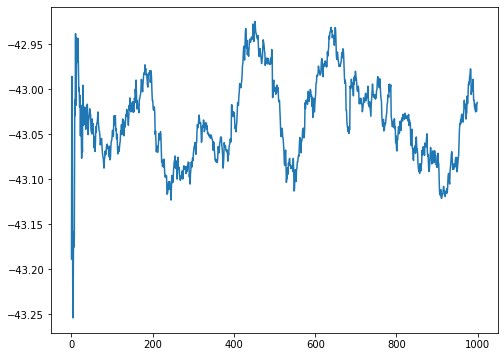

In [10]:
plot_result(["expected_sarsa_agent", "random_agent"])